In [1]:
import covidcast
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

%cd ../code
from model import Model, ModelGamma

%cd ../notebooks

/home/xiavatar/Desktop/covidcast_latest/covidcast-nowcast/conv_models/code
/home/xiavatar/Desktop/covidcast_latest/covidcast-nowcast/conv_models/notebooks


In [2]:
#Load data
start_date = datetime(2020, 10, 15)
end_date = datetime(2020, 12, 15)
    
X_df = covidcast.signal(
        'fb-survey', 
        'smoothed_cli',
        start_date, end_date,
        geo_type='state')

Y_df = covidcast.signal(
        'indicator-combination',
        'confirmed_7dav_incidence_num',
        start_date, end_date,
        geo_type='state')

In [3]:
#Process data for use in Tensorflow
states = ['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'de', 'fl', 'ga',
       'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me',
       'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm',
       'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn',
       'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']

df = X_df.sort_values(['geo_value', 'time_value'])
df = df[df['geo_value'].isin(states)]
X = pd.pivot_table(df,index='geo_value',columns=df.groupby(['geo_value']).cumcount().add(1), values='value').values
X = tf.transpose(X, perm=[1,0])
X = tf.expand_dims(X,axis=0) #shape=(1,time series values, number of geo_values)
X = tf.cast(X, dtype=tf.float32)

df = Y_df.sort_values(['geo_value', 'time_value'])
df = df[df['geo_value'].isin(states)]
Y = pd.pivot_table(df,index='geo_value',columns=df.groupby(['geo_value']).cumcount().add(1), values='value').values
Y = tf.transpose(Y, perm=[1,0])
Y = tf.expand_dims(Y,axis=0) #shape=(1, time series values, number of geo_values)
Y = tf.cast(Y, dtype=tf.float32)

In [14]:
#Initialize model without filter bank

#You can apply constraints directly to layers by setting
#the kernel_constraints parameter for a specific layer
#
#https://www.tensorflow.org/api_docs/python/tf/keras/constraints

#You can also apply losses directly on the weights of a layer
#by setting the kernel_regularizer parameter
#
#https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer
p = 30
m = X.shape[2] #number of geo_values
#kernel_constraint = tf.keras.constraints.NonNeg()
kernel_regularizer = None 
lr = 0.1

model_a = ModelGamma(
    p = p, 
    m = m,
    #kernel_constraint = kernel_constraint,
    kernel_regularizer = kernel_regularizer,
    lam=1,
)
optimizer = tf.keras.optimizers.Adam(lr = lr)

def MSE(y_true, y_pred):
    return tf.reduce_mean((y_true-y_pred)**2)
loss = MSE

#This just monitors the specified quantity
#and creates a checkpoint when the monitored quantity is 
#lower than the previous recorded value

MODEL_A_PATH = "model_a.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = MODEL_A_PATH,
    verbose = 0,
    monitor = "MSE",
    mode = 'min',
    save_best_only = True,
    save_weights_only = True
)
callbacks = [
    checkpoint_callback,
]

model_a.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = [loss],
)

In [15]:
#Training
hist = model_a.fit(
    x = X,
    y = Y,
    callbacks = callbacks,
   epochs = 10000,
)

Epoch 1/10000
1/1 [==============================] - 0s 251ms/step - MSE: 15579721.0000
Epoch 2/10000
1/1 [==============================] - 0s 20ms/step - MSE: 15579230.0000
Epoch 3/10000
1/1 [==============================] - 0s 22ms/step - MSE: 15578600.0000
Epoch 4/10000
1/1 [==============================] - 0s 23ms/step - MSE: 15577782.0000
Epoch 5/10000
1/1 [==============================] - 0s 23ms/step - MSE: 15576698.0000
Epoch 6/10000
1/1 [==============================] - 0s 22ms/step - MSE: 15575238.0000
Epoch 7/10000
1/1 [==============================] - 0s 21ms/step - MSE: 15573226.0000
Epoch 8/10000
1/1 [==============================] - 0s 20ms/step - MSE: 15570394.0000
Epoch 9/10000
1/1 [==============================] - 0s 21ms/step - MSE: 15566316.0000
Epoch 10/10000
1/1 [==============================] - 0s 21ms/step - MSE: 15560277.0000
Epoch 11/10000
1/1 [==============================] - 0s 21ms/step - MSE: 15551070.0000
Epoch 12/10000
1/1 [====================

1/1 [==============================] - 0s 649us/step - MSE: 8462981.0000
Epoch 94/10000
1/1 [==============================] - 0s 564us/step - MSE: 8225222.0000
Epoch 95/10000
1/1 [==============================] - 0s 498us/step - MSE: 7928869.5000
Epoch 96/10000
1/1 [==============================] - 0s 572us/step - MSE: 7999627.5000
Epoch 97/10000
1/1 [==============================] - 0s 481us/step - MSE: 8068947.5000
Epoch 98/10000
1/1 [==============================] - 0s 658us/step - MSE: 8076510.5000
Epoch 99/10000
1/1 [==============================] - 0s 588us/step - MSE: 8080026.0000
Epoch 100/10000
1/1 [==============================] - 0s 617us/step - MSE: 8017503.0000
Epoch 101/10000
1/1 [==============================] - 0s 556us/step - MSE: 7788363.5000
Epoch 102/10000
1/1 [==============================] - 0s 506us/step - MSE: 7656392.5000
Epoch 103/10000
1/1 [==============================] - 0s 803us/step - MSE: 7752785.5000
Epoch 104/10000
1/1 [======================

1/1 [==============================] - 0s 554us/step - MSE: 6566668.0000
Epoch 186/10000
1/1 [==============================] - 0s 489us/step - MSE: 6561102.5000
Epoch 187/10000
1/1 [==============================] - 0s 548us/step - MSE: 6553373.5000
Epoch 188/10000
1/1 [==============================] - 0s 505us/step - MSE: 6546229.0000
Epoch 189/10000
1/1 [==============================] - 0s 527us/step - MSE: 6541493.5000
Epoch 190/10000
1/1 [==============================] - 0s 509us/step - MSE: 6539556.0000
Epoch 191/10000
1/1 [==============================] - 0s 492us/step - MSE: 6537765.0000
Epoch 192/10000
1/1 [==============================] - 0s 509us/step - MSE: 6531705.0000
Epoch 193/10000
1/1 [==============================] - 0s 493us/step - MSE: 6521675.5000
Epoch 194/10000
1/1 [==============================] - 0s 854us/step - MSE: 6511884.0000
Epoch 195/10000
1/1 [==============================] - 0s 559us/step - MSE: 6505514.5000
Epoch 196/10000
1/1 [================

1/1 [==============================] - 0s 855us/step - MSE: 6119802.5000
Epoch 278/10000
1/1 [==============================] - 0s 599us/step - MSE: 6118529.0000
Epoch 279/10000
1/1 [==============================] - 0s 682us/step - MSE: 6117655.5000
Epoch 280/10000
1/1 [==============================] - 0s 521us/step - MSE: 6117432.0000
Epoch 281/10000
1/1 [==============================] - 0s 528us/step - MSE: 6117610.0000
Epoch 282/10000
1/1 [==============================] - 0s 511us/step - MSE: 6118751.0000
Epoch 283/10000
1/1 [==============================] - 0s 704us/step - MSE: 6117489.5000
Epoch 284/10000
1/1 [==============================] - 0s 546us/step - MSE: 6118143.5000
Epoch 285/10000
1/1 [==============================] - 0s 496us/step - MSE: 6114687.0000
Epoch 286/10000
1/1 [==============================] - 0s 525us/step - MSE: 6113816.5000
Epoch 287/10000
1/1 [==============================] - 0s 585us/step - MSE: 6114664.5000
Epoch 288/10000
1/1 [================

1/1 [==============================] - 0s 492us/step - MSE: 6107098.5000
Epoch 370/10000
1/1 [==============================] - 0s 489us/step - MSE: 6104908.5000
Epoch 371/10000
1/1 [==============================] - 0s 624us/step - MSE: 6102609.5000
Epoch 372/10000
1/1 [==============================] - 0s 576us/step - MSE: 6100192.5000
Epoch 373/10000
1/1 [==============================] - 0s 514us/step - MSE: 6097651.0000
Epoch 374/10000
1/1 [==============================] - 0s 499us/step - MSE: 6094990.5000
Epoch 375/10000
1/1 [==============================] - 0s 664us/step - MSE: 6092201.5000
Epoch 376/10000
1/1 [==============================] - 0s 553us/step - MSE: 6089418.0000
Epoch 377/10000
1/1 [==============================] - 0s 528us/step - MSE: 6086428.5000
Epoch 378/10000
1/1 [==============================] - 0s 713us/step - MSE: 6084180.0000
Epoch 379/10000
1/1 [==============================] - 0s 575us/step - MSE: 6079862.0000
Epoch 380/10000
1/1 [================

1/1 [==============================] - 0s 489us/step - MSE: 4907401.5000
Epoch 462/10000
1/1 [==============================] - 0s 538us/step - MSE: 4909869.0000
Epoch 463/10000
1/1 [==============================] - 0s 507us/step - MSE: 4908286.0000
Epoch 464/10000
1/1 [==============================] - 0s 586us/step - MSE: 4904340.0000
Epoch 465/10000
1/1 [==============================] - 0s 566us/step - MSE: 4900173.0000
Epoch 466/10000
1/1 [==============================] - 0s 486us/step - MSE: 4899434.5000
Epoch 467/10000
1/1 [==============================] - 0s 502us/step - MSE: 4901198.0000
Epoch 468/10000
1/1 [==============================] - 0s 668us/step - MSE: 4902769.5000
Epoch 469/10000
1/1 [==============================] - 0s 541us/step - MSE: 4900431.0000
Epoch 470/10000
1/1 [==============================] - 0s 495us/step - MSE: 4897136.5000
Epoch 471/10000
1/1 [==============================] - 0s 492us/step - MSE: 4895419.0000
Epoch 472/10000
1/1 [================

1/1 [==============================] - 0s 513us/step - MSE: 4707689.0000
Epoch 554/10000
1/1 [==============================] - 0s 486us/step - MSE: 4704417.0000
Epoch 555/10000
1/1 [==============================] - 0s 1ms/step - MSE: 4700745.0000
Epoch 556/10000
1/1 [==============================] - 0s 601us/step - MSE: 4696911.0000
Epoch 557/10000
1/1 [==============================] - 0s 474us/step - MSE: 4691229.0000
Epoch 558/10000
1/1 [==============================] - 0s 513us/step - MSE: 4686241.5000
Epoch 559/10000
1/1 [==============================] - 0s 746us/step - MSE: 4677312.0000
Epoch 560/10000
1/1 [==============================] - 0s 823us/step - MSE: 4671986.0000
Epoch 561/10000
1/1 [==============================] - 0s 486us/step - MSE: 4656124.0000
Epoch 562/10000
1/1 [==============================] - 0s 512us/step - MSE: 4643431.0000
Epoch 563/10000
1/1 [==============================] - 0s 643us/step - MSE: 4620900.5000
Epoch 564/10000
1/1 [==================

1/1 [==============================] - 0s 529us/step - MSE: 4419541.0000
Epoch 646/10000
1/1 [==============================] - 0s 516us/step - MSE: 4421240.5000
Epoch 647/10000
1/1 [==============================] - 0s 594us/step - MSE: 4418116.0000
Epoch 648/10000
1/1 [==============================] - 0s 545us/step - MSE: 4415635.5000
Epoch 649/10000
1/1 [==============================] - 0s 559us/step - MSE: 4413397.0000
Epoch 650/10000
1/1 [==============================] - 0s 501us/step - MSE: 4414443.5000
Epoch 651/10000
1/1 [==============================] - 0s 514us/step - MSE: 4411333.5000
Epoch 652/10000
1/1 [==============================] - 0s 617us/step - MSE: 4409992.0000
Epoch 653/10000
1/1 [==============================] - 0s 695us/step - MSE: 4409454.5000
Epoch 654/10000
1/1 [==============================] - 0s 473us/step - MSE: 4409334.0000
Epoch 655/10000
1/1 [==============================] - 0s 539us/step - MSE: 4406883.5000
Epoch 656/10000
1/1 [================

1/1 [==============================] - 0s 722us/step - MSE: 1368260.6250
Epoch 738/10000
1/1 [==============================] - 0s 684us/step - MSE: 1015981.9375
Epoch 739/10000
1/1 [==============================] - 0s 568us/step - MSE: 878360.2500
Epoch 740/10000
1/1 [==============================] - 0s 557us/step - MSE: 1327264.6250
Epoch 741/10000
1/1 [==============================] - 0s 487us/step - MSE: 1215866.5000
Epoch 742/10000
1/1 [==============================] - 0s 22ms/step - MSE: 866086.0000
Epoch 743/10000
1/1 [==============================] - 0s 529us/step - MSE: 970929.6875
Epoch 744/10000
1/1 [==============================] - 0s 510us/step - MSE: 1139432.3750
Epoch 745/10000
1/1 [==============================] - 0s 603us/step - MSE: 1183045.7500
Epoch 746/10000
1/1 [==============================] - 0s 547us/step - MSE: 1090054.5000
Epoch 747/10000
1/1 [==============================] - 0s 517us/step - MSE: 926953.5625
Epoch 748/10000
1/1 [=====================

1/1 [==============================] - 0s 563us/step - MSE: 850160.8750
Epoch 831/10000
1/1 [==============================] - 0s 20ms/step - MSE: 849528.1250
Epoch 832/10000
1/1 [==============================] - 0s 550us/step - MSE: 849927.2500
Epoch 833/10000
1/1 [==============================] - 0s 20ms/step - MSE: 849205.6875
Epoch 834/10000
1/1 [==============================] - 0s 540us/step - MSE: 849632.3750
Epoch 835/10000
1/1 [==============================] - 0s 19ms/step - MSE: 848932.0000
Epoch 836/10000
1/1 [==============================] - 0s 600us/step - MSE: 849370.7500
Epoch 837/10000
1/1 [==============================] - 0s 19ms/step - MSE: 848708.1250
Epoch 838/10000
1/1 [==============================] - 0s 563us/step - MSE: 849123.1875
Epoch 839/10000
1/1 [==============================] - 0s 20ms/step - MSE: 848473.6250
Epoch 840/10000
1/1 [==============================] - 0s 518us/step - MSE: 848822.2500
Epoch 841/10000
1/1 [==============================] 

1/1 [==============================] - 0s 535us/step - MSE: 840212.1250
Epoch 924/10000
1/1 [==============================] - 0s 595us/step - MSE: 840413.8750
Epoch 925/10000
1/1 [==============================] - 0s 22ms/step - MSE: 839434.2500
Epoch 926/10000
1/1 [==============================] - 0s 581us/step - MSE: 839886.0625
Epoch 927/10000
1/1 [==============================] - 0s 19ms/step - MSE: 838644.6250
Epoch 928/10000
1/1 [==============================] - 0s 543us/step - MSE: 839024.0000
Epoch 929/10000
1/1 [==============================] - 0s 20ms/step - MSE: 837980.0000
Epoch 930/10000
1/1 [==============================] - 0s 532us/step - MSE: 838400.6875
Epoch 931/10000
1/1 [==============================] - 0s 21ms/step - MSE: 837558.2500
Epoch 932/10000
1/1 [==============================] - 0s 598us/step - MSE: 838065.0000
Epoch 933/10000
1/1 [==============================] - 0s 20ms/step - MSE: 837336.1250
Epoch 934/10000
1/1 [==============================] 

1/1 [==============================] - 0s 887us/step - MSE: 829870.6875
Epoch 1017/10000
1/1 [==============================] - 0s 27ms/step - MSE: 829282.6250
Epoch 1018/10000
1/1 [==============================] - 0s 665us/step - MSE: 829746.8125
Epoch 1019/10000
1/1 [==============================] - 0s 22ms/step - MSE: 829190.5000
Epoch 1020/10000
1/1 [==============================] - 0s 676us/step - MSE: 829620.0000
Epoch 1021/10000
1/1 [==============================] - 0s 22ms/step - MSE: 829079.6875
Epoch 1022/10000
1/1 [==============================] - 0s 631us/step - MSE: 829469.6250
Epoch 1023/10000
1/1 [==============================] - 0s 22ms/step - MSE: 828918.9375
Epoch 1024/10000
1/1 [==============================] - 0s 549us/step - MSE: 829286.8125
Epoch 1025/10000
1/1 [==============================] - 0s 21ms/step - MSE: 828709.5000
Epoch 1026/10000
1/1 [==============================] - 0s 527us/step - MSE: 829094.2500
Epoch 1027/10000
1/1 [=====================

1/1 [==============================] - 0s 529us/step - MSE: 822055.2500
Epoch 1109/10000
1/1 [==============================] - 0s 21ms/step - MSE: 821512.8125
Epoch 1110/10000
1/1 [==============================] - 0s 510us/step - MSE: 821971.6250
Epoch 1111/10000
1/1 [==============================] - 0s 20ms/step - MSE: 821503.8125
Epoch 1112/10000
1/1 [==============================] - 0s 583us/step - MSE: 821971.6250
Epoch 1113/10000
1/1 [==============================] - 0s 610us/step - MSE: 821608.6875
Epoch 1114/10000
1/1 [==============================] - 0s 536us/step - MSE: 822018.0625
Epoch 1115/10000
1/1 [==============================] - 0s 829us/step - MSE: 821656.1875
Epoch 1116/10000
1/1 [==============================] - 0s 758us/step - MSE: 822044.4375
Epoch 1117/10000
1/1 [==============================] - 0s 20ms/step - MSE: 821492.1875
Epoch 1118/10000
1/1 [==============================] - 0s 573us/step - MSE: 822030.1250
Epoch 1119/10000
1/1 [===================

1/1 [==============================] - 0s 571us/step - MSE: 815390.5000
Epoch 1201/10000
1/1 [==============================] - 0s 22ms/step - MSE: 814911.0625
Epoch 1202/10000
1/1 [==============================] - 0s 566us/step - MSE: 815454.6250
Epoch 1203/10000
1/1 [==============================] - 0s 514us/step - MSE: 815085.4375
Epoch 1204/10000
1/1 [==============================] - 0s 530us/step - MSE: 815734.4375
Epoch 1205/10000
1/1 [==============================] - 0s 613us/step - MSE: 815437.8125
Epoch 1206/10000
1/1 [==============================] - 0s 508us/step - MSE: 816015.3750
Epoch 1207/10000
1/1 [==============================] - 0s 512us/step - MSE: 815465.4375
Epoch 1208/10000
1/1 [==============================] - 0s 554us/step - MSE: 815648.5625
Epoch 1209/10000
1/1 [==============================] - 0s 20ms/step - MSE: 814864.0000
Epoch 1210/10000
1/1 [==============================] - 0s 554us/step - MSE: 815002.7500
Epoch 1211/10000
1/1 [==================

1/1 [==============================] - 0s 645us/step - MSE: 809962.3125
Epoch 1293/10000
1/1 [==============================] - 0s 545us/step - MSE: 809330.3750
Epoch 1294/10000
1/1 [==============================] - 0s 529us/step - MSE: 810054.1250
Epoch 1295/10000
1/1 [==============================] - 0s 521us/step - MSE: 809319.1250
Epoch 1296/10000
1/1 [==============================] - 0s 590us/step - MSE: 809982.6875
Epoch 1297/10000
1/1 [==============================] - 0s 550us/step - MSE: 809305.7500
Epoch 1298/10000
1/1 [==============================] - 0s 560us/step - MSE: 809874.0625
Epoch 1299/10000
1/1 [==============================] - 0s 584us/step - MSE: 809439.3750
Epoch 1300/10000
1/1 [==============================] - 0s 487us/step - MSE: 809730.0625
Epoch 1301/10000
1/1 [==============================] - 0s 540us/step - MSE: 809460.4375
Epoch 1302/10000
1/1 [==============================] - 0s 582us/step - MSE: 809413.9375
Epoch 1303/10000
1/1 [================

1/1 [==============================] - 0s 557us/step - MSE: 805017.2500
Epoch 1385/10000
1/1 [==============================] - 0s 495us/step - MSE: 804416.0625
Epoch 1386/10000
1/1 [==============================] - 0s 544us/step - MSE: 805214.0000
Epoch 1387/10000
1/1 [==============================] - 0s 794us/step - MSE: 804433.9375
Epoch 1388/10000
1/1 [==============================] - 0s 560us/step - MSE: 805107.9375
Epoch 1389/10000
1/1 [==============================] - 0s 483us/step - MSE: 804322.0000
Epoch 1390/10000
1/1 [==============================] - 0s 521us/step - MSE: 804895.0625
Epoch 1391/10000
1/1 [==============================] - 0s 518us/step - MSE: 804257.1250
Epoch 1392/10000
1/1 [==============================] - 0s 527us/step - MSE: 804789.3750
Epoch 1393/10000
1/1 [==============================] - 0s 487us/step - MSE: 804425.4375
Epoch 1394/10000
1/1 [==============================] - 0s 683us/step - MSE: 804747.8750
Epoch 1395/10000
1/1 [================

1/1 [==============================] - 0s 928us/step - MSE: 800382.8750
Epoch 1477/10000
1/1 [==============================] - 0s 22ms/step - MSE: 799599.2500
Epoch 1478/10000
1/1 [==============================] - 0s 511us/step - MSE: 800195.4375
Epoch 1479/10000
1/1 [==============================] - 0s 24ms/step - MSE: 799529.0625
Epoch 1480/10000
1/1 [==============================] - 0s 504us/step - MSE: 800312.1250
Epoch 1481/10000
1/1 [==============================] - 0s 20ms/step - MSE: 799528.6875
Epoch 1482/10000
1/1 [==============================] - 0s 520us/step - MSE: 800177.6875
Epoch 1483/10000
1/1 [==============================] - 0s 21ms/step - MSE: 799312.8750
Epoch 1484/10000
1/1 [==============================] - 0s 619us/step - MSE: 799716.0000
Epoch 1485/10000
1/1 [==============================] - 0s 21ms/step - MSE: 798950.5000
Epoch 1486/10000
1/1 [==============================] - 0s 784us/step - MSE: 799305.5000
Epoch 1487/10000
1/1 [=====================

1/1 [==============================] - 0s 793us/step - MSE: 797157.0625
Epoch 1569/10000
1/1 [==============================] - 0s 582us/step - MSE: 796488.0000
Epoch 1570/10000
1/1 [==============================] - 0s 1ms/step - MSE: 797007.4375
Epoch 1571/10000
1/1 [==============================] - 0s 510us/step - MSE: 796423.8750
Epoch 1572/10000
1/1 [==============================] - 0s 509us/step - MSE: 796933.3750
Epoch 1573/10000
1/1 [==============================] - 0s 616us/step - MSE: 796418.0625
Epoch 1574/10000
1/1 [==============================] - 0s 506us/step - MSE: 796915.4375
Epoch 1575/10000
1/1 [==============================] - 0s 508us/step - MSE: 796429.8750
Epoch 1576/10000
1/1 [==============================] - 0s 540us/step - MSE: 796894.0625
Epoch 1577/10000
1/1 [==============================] - 0s 531us/step - MSE: 796387.0000
Epoch 1578/10000
1/1 [==============================] - 0s 575us/step - MSE: 796804.4375
Epoch 1579/10000
1/1 [==================

1/1 [==============================] - 0s 511us/step - MSE: 798380.6875
Epoch 1661/10000
1/1 [==============================] - 0s 494us/step - MSE: 795065.2500
Epoch 1662/10000
1/1 [==============================] - 0s 513us/step - MSE: 795162.1250
Epoch 1663/10000
1/1 [==============================] - 0s 560us/step - MSE: 793899.7500
Epoch 1664/10000
1/1 [==============================] - 0s 506us/step - MSE: 794324.6250
Epoch 1665/10000
1/1 [==============================] - 0s 527us/step - MSE: 793913.6250
Epoch 1666/10000
1/1 [==============================] - 0s 589us/step - MSE: 794534.3125
Epoch 1667/10000
1/1 [==============================] - 0s 686us/step - MSE: 794619.0625
Epoch 1668/10000
1/1 [==============================] - 0s 597us/step - MSE: 795304.0000
Epoch 1669/10000
1/1 [==============================] - 0s 666us/step - MSE: 795755.1875
Epoch 1670/10000
1/1 [==============================] - 0s 542us/step - MSE: 796542.9375
Epoch 1671/10000
1/1 [================

1/1 [==============================] - 0s 639us/step - MSE: 791656.3750
Epoch 1753/10000
1/1 [==============================] - 0s 493us/step - MSE: 790778.0000
Epoch 1754/10000
1/1 [==============================] - 0s 551us/step - MSE: 791720.0625
Epoch 1755/10000
1/1 [==============================] - 0s 650us/step - MSE: 790824.6250
Epoch 1756/10000
1/1 [==============================] - 0s 517us/step - MSE: 791842.6875
Epoch 1757/10000
1/1 [==============================] - 0s 649us/step - MSE: 790896.0000
Epoch 1758/10000
1/1 [==============================] - 0s 531us/step - MSE: 791962.1875
Epoch 1759/10000
1/1 [==============================] - 0s 536us/step - MSE: 790941.8125
Epoch 1760/10000
1/1 [==============================] - 0s 706us/step - MSE: 792008.6875
Epoch 1761/10000
1/1 [==============================] - 0s 517us/step - MSE: 790920.4375
Epoch 1762/10000
1/1 [==============================] - 0s 783us/step - MSE: 791932.7500
Epoch 1763/10000
1/1 [================

1/1 [==============================] - 0s 537us/step - MSE: 792189.4375
Epoch 1845/10000
1/1 [==============================] - 0s 502us/step - MSE: 792805.5000
Epoch 1846/10000
1/1 [==============================] - 0s 664us/step - MSE: 792419.8125
Epoch 1847/10000
1/1 [==============================] - 0s 540us/step - MSE: 792419.9375
Epoch 1848/10000
1/1 [==============================] - 0s 575us/step - MSE: 791875.6250
Epoch 1849/10000
1/1 [==============================] - 0s 479us/step - MSE: 791249.4375
Epoch 1850/10000
1/1 [==============================] - 0s 593us/step - MSE: 790980.1875
Epoch 1851/10000
1/1 [==============================] - 0s 719us/step - MSE: 790021.5625
Epoch 1852/10000
1/1 [==============================] - 0s 490us/step - MSE: 790111.1875
Epoch 1853/10000
1/1 [==============================] - 0s 531us/step - MSE: 789040.1250
Epoch 1854/10000
1/1 [==============================] - 0s 483us/step - MSE: 789417.8125
Epoch 1855/10000
1/1 [================

1/1 [==============================] - 0s 502us/step - MSE: 786682.0000
Epoch 1937/10000
1/1 [==============================] - 0s 566us/step - MSE: 785779.0625
Epoch 1938/10000
1/1 [==============================] - 0s 1ms/step - MSE: 786779.9375
Epoch 1939/10000
1/1 [==============================] - 0s 609us/step - MSE: 785892.6875
Epoch 1940/10000
1/1 [==============================] - 0s 628us/step - MSE: 786950.4375
Epoch 1941/10000
1/1 [==============================] - 0s 483us/step - MSE: 786105.0000
Epoch 1942/10000
1/1 [==============================] - 0s 634us/step - MSE: 787289.4375
Epoch 1943/10000
1/1 [==============================] - 0s 607us/step - MSE: 786495.5000
Epoch 1944/10000
1/1 [==============================] - 0s 548us/step - MSE: 787926.4375
Epoch 1945/10000
1/1 [==============================] - 0s 518us/step - MSE: 787109.4375
Epoch 1946/10000
1/1 [==============================] - 0s 796us/step - MSE: 788902.5000
Epoch 1947/10000
1/1 [==================

1/1 [==============================] - 0s 825us/step - MSE: 784146.4375
Epoch 2029/10000
1/1 [==============================] - 0s 20ms/step - MSE: 783181.8750
Epoch 2030/10000
1/1 [==============================] - 0s 513us/step - MSE: 784008.5000
Epoch 2031/10000
1/1 [==============================] - 0s 21ms/step - MSE: 783080.8125
Epoch 2032/10000
1/1 [==============================] - 0s 541us/step - MSE: 783914.9375
Epoch 2033/10000
1/1 [==============================] - 0s 20ms/step - MSE: 783006.3750
Epoch 2034/10000
1/1 [==============================] - 0s 724us/step - MSE: 783852.0000
Epoch 2035/10000
1/1 [==============================] - 0s 23ms/step - MSE: 782948.2500
Epoch 2036/10000
1/1 [==============================] - 0s 977us/step - MSE: 783803.6875
Epoch 2037/10000
1/1 [==============================] - 0s 24ms/step - MSE: 782896.1250
Epoch 2038/10000
1/1 [==============================] - 0s 531us/step - MSE: 783760.5000
Epoch 2039/10000
1/1 [=====================

1/1 [==============================] - 0s 559us/step - MSE: 786514.5000
Epoch 2121/10000
1/1 [==============================] - 0s 578us/step - MSE: 784495.2500
Epoch 2122/10000
1/1 [==============================] - 0s 542us/step - MSE: 786460.4375
Epoch 2123/10000
1/1 [==============================] - 0s 579us/step - MSE: 783911.0625
Epoch 2124/10000
1/1 [==============================] - 0s 566us/step - MSE: 785033.3125
Epoch 2125/10000
1/1 [==============================] - 0s 556us/step - MSE: 782769.0000
Epoch 2126/10000
1/1 [==============================] - 0s 515us/step - MSE: 783433.8125
Epoch 2127/10000
1/1 [==============================] - 0s 575us/step - MSE: 781768.5000
Epoch 2128/10000
1/1 [==============================] - 0s 578us/step - MSE: 782426.3125
Epoch 2129/10000
1/1 [==============================] - 0s 30ms/step - MSE: 781183.1875
Epoch 2130/10000
1/1 [==============================] - 0s 667us/step - MSE: 781961.9375
Epoch 2131/10000
1/1 [=================

1/1 [==============================] - 0s 535us/step - MSE: 783889.7500
Epoch 2213/10000
1/1 [==============================] - 0s 554us/step - MSE: 783238.4375
Epoch 2214/10000
1/1 [==============================] - 0s 495us/step - MSE: 782860.9375
Epoch 2215/10000
1/1 [==============================] - 0s 488us/step - MSE: 782211.4375
Epoch 2216/10000
1/1 [==============================] - 0s 546us/step - MSE: 782671.0000
Epoch 2217/10000
1/1 [==============================] - 0s 533us/step - MSE: 782301.1250
Epoch 2218/10000
1/1 [==============================] - 0s 624us/step - MSE: 782849.0625
Epoch 2219/10000
1/1 [==============================] - 0s 469us/step - MSE: 782835.0625
Epoch 2220/10000
1/1 [==============================] - 0s 607us/step - MSE: 783125.0625
Epoch 2221/10000
1/1 [==============================] - 0s 504us/step - MSE: 783056.2500
Epoch 2222/10000
1/1 [==============================] - 0s 620us/step - MSE: 783104.2500
Epoch 2223/10000
1/1 [================

1/1 [==============================] - 0s 778us/step - MSE: 780078.4375
Epoch 2305/10000
1/1 [==============================] - 0s 796us/step - MSE: 779657.2500
Epoch 2306/10000
1/1 [==============================] - 0s 634us/step - MSE: 780085.7500
Epoch 2307/10000
1/1 [==============================] - 0s 642us/step - MSE: 779657.4375
Epoch 2308/10000
1/1 [==============================] - 0s 585us/step - MSE: 780035.6875
Epoch 2309/10000
1/1 [==============================] - 0s 577us/step - MSE: 779583.9375
Epoch 2310/10000
1/1 [==============================] - 0s 605us/step - MSE: 779930.4375
Epoch 2311/10000
1/1 [==============================] - 0s 643us/step - MSE: 779444.1250
Epoch 2312/10000
1/1 [==============================] - 0s 648us/step - MSE: 779789.6875
Epoch 2313/10000
1/1 [==============================] - 0s 22ms/step - MSE: 779267.8125
Epoch 2314/10000
1/1 [==============================] - 0s 673us/step - MSE: 779650.2500
Epoch 2315/10000
1/1 [=================

1/1 [==============================] - 0s 551us/step - MSE: 780615.1250
Epoch 2397/10000
1/1 [==============================] - 0s 547us/step - MSE: 780180.3125
Epoch 2398/10000
1/1 [==============================] - 0s 595us/step - MSE: 779523.8125
Epoch 2399/10000
1/1 [==============================] - 0s 489us/step - MSE: 778777.6875
Epoch 2400/10000
1/1 [==============================] - 0s 497us/step - MSE: 778702.5625
Epoch 2401/10000
1/1 [==============================] - 0s 21ms/step - MSE: 778003.4375
Epoch 2402/10000
1/1 [==============================] - 0s 517us/step - MSE: 778278.5000
Epoch 2403/10000
1/1 [==============================] - 0s 22ms/step - MSE: 777686.5625
Epoch 2404/10000
1/1 [==============================] - 0s 727us/step - MSE: 778123.2500
Epoch 2405/10000
1/1 [==============================] - 0s 22ms/step - MSE: 777603.3750
Epoch 2406/10000
1/1 [==============================] - 0s 658us/step - MSE: 778104.8750
Epoch 2407/10000
1/1 [===================

1/1 [==============================] - 0s 527us/step - MSE: 778628.3125
Epoch 2489/10000
1/1 [==============================] - 0s 631us/step - MSE: 778190.3750
Epoch 2490/10000
1/1 [==============================] - 0s 632us/step - MSE: 779582.7500
Epoch 2491/10000
1/1 [==============================] - 0s 616us/step - MSE: 778811.5625
Epoch 2492/10000
1/1 [==============================] - 0s 495us/step - MSE: 780486.2500
Epoch 2493/10000
1/1 [==============================] - 0s 863us/step - MSE: 779159.9375
Epoch 2494/10000
1/1 [==============================] - 0s 542us/step - MSE: 780583.5625
Epoch 2495/10000
1/1 [==============================] - 0s 740us/step - MSE: 778839.6250
Epoch 2496/10000
1/1 [==============================] - 0s 497us/step - MSE: 779653.3125
Epoch 2497/10000
1/1 [==============================] - 0s 710us/step - MSE: 778003.0625
Epoch 2498/10000
1/1 [==============================] - 0s 600us/step - MSE: 778387.8125
Epoch 2499/10000
1/1 [================

1/1 [==============================] - 0s 469us/step - MSE: 776024.0000
Epoch 2581/10000
1/1 [==============================] - 0s 675us/step - MSE: 775967.3125
Epoch 2582/10000
1/1 [==============================] - 0s 699us/step - MSE: 775811.8125
Epoch 2583/10000
1/1 [==============================] - 0s 545us/step - MSE: 775312.5000
Epoch 2584/10000
1/1 [==============================] - 0s 483us/step - MSE: 775302.0000
Epoch 2585/10000
1/1 [==============================] - 0s 30ms/step - MSE: 774667.8125
Epoch 2586/10000
1/1 [==============================] - 0s 623us/step - MSE: 774955.8750
Epoch 2587/10000
1/1 [==============================] - 0s 30ms/step - MSE: 774468.4375
Epoch 2588/10000
1/1 [==============================] - 0s 792us/step - MSE: 774964.5000
Epoch 2589/10000
1/1 [==============================] - 0s 546us/step - MSE: 774663.1250
Epoch 2590/10000
1/1 [==============================] - 0s 518us/step - MSE: 775310.6250
Epoch 2591/10000
1/1 [==================

1/1 [==============================] - 0s 667us/step - MSE: 775485.4375
Epoch 2673/10000
1/1 [==============================] - 0s 702us/step - MSE: 776708.3750
Epoch 2674/10000
1/1 [==============================] - 0s 626us/step - MSE: 777221.9375
Epoch 2675/10000
1/1 [==============================] - 0s 541us/step - MSE: 779878.6250
Epoch 2676/10000
1/1 [==============================] - 0s 553us/step - MSE: 778504.9375
Epoch 2677/10000
1/1 [==============================] - 0s 550us/step - MSE: 780406.3125
Epoch 2678/10000
1/1 [==============================] - 0s 533us/step - MSE: 777601.5000
Epoch 2679/10000
1/1 [==============================] - 0s 485us/step - MSE: 777235.8750
Epoch 2680/10000
1/1 [==============================] - 0s 525us/step - MSE: 775646.8750
Epoch 2681/10000
1/1 [==============================] - 0s 515us/step - MSE: 774726.9375
Epoch 2682/10000
1/1 [==============================] - 0s 627us/step - MSE: 774339.6875
Epoch 2683/10000
1/1 [================

1/1 [==============================] - 0s 564us/step - MSE: 773806.7500
Epoch 2765/10000
1/1 [==============================] - 0s 521us/step - MSE: 773503.1875
Epoch 2766/10000
1/1 [==============================] - 0s 606us/step - MSE: 774892.6875
Epoch 2767/10000
1/1 [==============================] - 0s 726us/step - MSE: 774356.7500
Epoch 2768/10000
1/1 [==============================] - 0s 514us/step - MSE: 775980.8125
Epoch 2769/10000
1/1 [==============================] - 0s 853us/step - MSE: 774942.8750
Epoch 2770/10000
1/1 [==============================] - 0s 593us/step - MSE: 776222.2500
Epoch 2771/10000
1/1 [==============================] - 0s 559us/step - MSE: 774880.5625
Epoch 2772/10000
1/1 [==============================] - 0s 489us/step - MSE: 775400.9375
Epoch 2773/10000
1/1 [==============================] - 0s 637us/step - MSE: 774225.0000
Epoch 2774/10000
1/1 [==============================] - 0s 656us/step - MSE: 774202.6875
Epoch 2775/10000
1/1 [================

1/1 [==============================] - 0s 426us/step - MSE: 774462.2500
Epoch 2857/10000
1/1 [==============================] - 0s 481us/step - MSE: 773131.8125
Epoch 2858/10000
1/1 [==============================] - 0s 439us/step - MSE: 773148.0000
Epoch 2859/10000
1/1 [==============================] - 0s 501us/step - MSE: 772049.3125
Epoch 2860/10000
1/1 [==============================] - 0s 551us/step - MSE: 772282.1250
Epoch 2861/10000
1/1 [==============================] - 0s 568us/step - MSE: 771496.6875
Epoch 2862/10000
1/1 [==============================] - 0s 526us/step - MSE: 771786.8125
Epoch 2863/10000
1/1 [==============================] - 0s 553us/step - MSE: 771257.3125
Epoch 2864/10000
1/1 [==============================] - 0s 595us/step - MSE: 771691.5000
Epoch 2865/10000
1/1 [==============================] - 0s 518us/step - MSE: 771322.4375
Epoch 2866/10000
1/1 [==============================] - 0s 691us/step - MSE: 772029.2500
Epoch 2867/10000
1/1 [================

1/1 [==============================] - 0s 627us/step - MSE: 771395.0000
Epoch 2949/10000
1/1 [==============================] - 0s 604us/step - MSE: 770366.1250
Epoch 2950/10000
1/1 [==============================] - 0s 600us/step - MSE: 770592.6250
Epoch 2951/10000
1/1 [==============================] - 0s 23ms/step - MSE: 769893.8125
Epoch 2952/10000
1/1 [==============================] - 0s 658us/step - MSE: 770255.0000
Epoch 2953/10000
1/1 [==============================] - 0s 143ms/step - MSE: 769712.0000
Epoch 2954/10000
1/1 [==============================] - 0s 569us/step - MSE: 770207.6250
Epoch 2955/10000
1/1 [==============================] - 0s 21ms/step - MSE: 769711.0000
Epoch 2956/10000
1/1 [==============================] - 0s 504us/step - MSE: 770319.3750
Epoch 2957/10000
1/1 [==============================] - 0s 552us/step - MSE: 769802.3125
Epoch 2958/10000
1/1 [==============================] - 0s 618us/step - MSE: 770491.0625
Epoch 2959/10000
1/1 [==================

1/1 [==============================] - 0s 546us/step - MSE: 770170.8125
Epoch 3041/10000
1/1 [==============================] - 0s 550us/step - MSE: 769854.1250
Epoch 3042/10000
1/1 [==============================] - 0s 713us/step - MSE: 771046.8125
Epoch 3043/10000
1/1 [==============================] - 0s 608us/step - MSE: 770732.3750
Epoch 3044/10000
1/1 [==============================] - 0s 619us/step - MSE: 772574.8750
Epoch 3045/10000
1/1 [==============================] - 0s 990us/step - MSE: 771819.6875
Epoch 3046/10000
1/1 [==============================] - 0s 712us/step - MSE: 774009.0625
Epoch 3047/10000
1/1 [==============================] - 0s 774us/step - MSE: 772368.7500
Epoch 3048/10000
1/1 [==============================] - 0s 578us/step - MSE: 773979.8125
Epoch 3049/10000
1/1 [==============================] - 0s 713us/step - MSE: 771995.1875
Epoch 3050/10000
1/1 [==============================] - 0s 647us/step - MSE: 772792.8750
Epoch 3051/10000
1/1 [================

1/1 [==============================] - 0s 666us/step - MSE: 773039.5000
Epoch 3133/10000
1/1 [==============================] - 0s 555us/step - MSE: 772088.3750
Epoch 3134/10000
1/1 [==============================] - 0s 502us/step - MSE: 774022.2500
Epoch 3135/10000
1/1 [==============================] - 0s 754us/step - MSE: 772422.4375
Epoch 3136/10000
1/1 [==============================] - 0s 762us/step - MSE: 773479.3750
Epoch 3137/10000
1/1 [==============================] - 0s 952us/step - MSE: 771681.5000
Epoch 3138/10000
1/1 [==============================] - 0s 572us/step - MSE: 771969.5625
Epoch 3139/10000
1/1 [==============================] - 0s 619us/step - MSE: 770467.4375
Epoch 3140/10000
1/1 [==============================] - 0s 706us/step - MSE: 770590.5625
Epoch 3141/10000
1/1 [==============================] - 0s 846us/step - MSE: 769507.1250
Epoch 3142/10000
1/1 [==============================] - 0s 745us/step - MSE: 769861.9375
Epoch 3143/10000
1/1 [================

1/1 [==============================] - 0s 559us/step - MSE: 769651.0625
Epoch 3225/10000
1/1 [==============================] - 0s 525us/step - MSE: 769187.2500
Epoch 3226/10000
1/1 [==============================] - 0s 619us/step - MSE: 768805.0000
Epoch 3227/10000
1/1 [==============================] - 0s 568us/step - MSE: 768241.4375
Epoch 3228/10000
1/1 [==============================] - 0s 541us/step - MSE: 769245.8125
Epoch 3229/10000
1/1 [==============================] - 0s 495us/step - MSE: 768561.6875
Epoch 3230/10000
1/1 [==============================] - 0s 689us/step - MSE: 770641.1875
Epoch 3231/10000
1/1 [==============================] - 0s 558us/step - MSE: 768850.6875
Epoch 3232/10000
1/1 [==============================] - 0s 501us/step - MSE: 770248.3125
Epoch 3233/10000
1/1 [==============================] - 0s 559us/step - MSE: 768142.8750
Epoch 3234/10000
1/1 [==============================] - 0s 577us/step - MSE: 768565.0000
Epoch 3235/10000
1/1 [================

1/1 [==============================] - 0s 814us/step - MSE: 773983.6875
Epoch 3317/10000
1/1 [==============================] - 0s 639us/step - MSE: 772760.1875
Epoch 3318/10000
1/1 [==============================] - 0s 669us/step - MSE: 773923.5625
Epoch 3319/10000
1/1 [==============================] - 0s 1ms/step - MSE: 772690.9375
Epoch 3320/10000
1/1 [==============================] - 0s 1ms/step - MSE: 772236.8750
Epoch 3321/10000
1/1 [==============================] - 0s 568us/step - MSE: 771187.7500
Epoch 3322/10000
1/1 [==============================] - 0s 535us/step - MSE: 769981.0000
Epoch 3323/10000
1/1 [==============================] - 0s 460us/step - MSE: 768945.0625
Epoch 3324/10000
1/1 [==============================] - 0s 638us/step - MSE: 768014.3750
Epoch 3325/10000
1/1 [==============================] - 0s 681us/step - MSE: 767064.4375
Epoch 3326/10000
1/1 [==============================] - 0s 563us/step - MSE: 766709.1250
Epoch 3327/10000
1/1 [====================

1/1 [==============================] - 0s 604us/step - MSE: 766338.3750
Epoch 3409/10000
1/1 [==============================] - 0s 619us/step - MSE: 766182.7500
Epoch 3410/10000
1/1 [==============================] - 0s 542us/step - MSE: 766714.8125
Epoch 3411/10000
1/1 [==============================] - 0s 504us/step - MSE: 766653.2500
Epoch 3412/10000
1/1 [==============================] - 0s 530us/step - MSE: 766887.5000
Epoch 3413/10000
1/1 [==============================] - 0s 585us/step - MSE: 766844.1250
Epoch 3414/10000
1/1 [==============================] - 0s 582us/step - MSE: 766910.9375
Epoch 3415/10000
1/1 [==============================] - 0s 537us/step - MSE: 766803.5625
Epoch 3416/10000
1/1 [==============================] - 0s 481us/step - MSE: 766941.5625
Epoch 3417/10000
1/1 [==============================] - 0s 826us/step - MSE: 766996.8750
Epoch 3418/10000
1/1 [==============================] - 0s 559us/step - MSE: 767410.4375
Epoch 3419/10000
1/1 [================

1/1 [==============================] - 0s 503us/step - MSE: 768915.5625
Epoch 3501/10000
1/1 [==============================] - 0s 596us/step - MSE: 768149.6875
Epoch 3502/10000
1/1 [==============================] - 0s 856us/step - MSE: 770823.6875
Epoch 3503/10000
1/1 [==============================] - 0s 488us/step - MSE: 768396.8750
Epoch 3504/10000
1/1 [==============================] - 0s 490us/step - MSE: 770941.2500
Epoch 3505/10000
1/1 [==============================] - 0s 584us/step - MSE: 767197.5625
Epoch 3506/10000
1/1 [==============================] - 0s 643us/step - MSE: 767758.6250
Epoch 3507/10000
1/1 [==============================] - 0s 549us/step - MSE: 765286.8750
Epoch 3508/10000
1/1 [==============================] - 0s 505us/step - MSE: 765382.1875
Epoch 3509/10000
1/1 [==============================] - 0s 621us/step - MSE: 764182.6250
Epoch 3510/10000
1/1 [==============================] - 0s 606us/step - MSE: 764557.9375
Epoch 3511/10000
1/1 [================

1/1 [==============================] - 0s 483us/step - MSE: 765393.1250
Epoch 3593/10000
1/1 [==============================] - 0s 522us/step - MSE: 765151.9375
Epoch 3594/10000
1/1 [==============================] - 0s 463us/step - MSE: 766443.4375
Epoch 3595/10000
1/1 [==============================] - 0s 555us/step - MSE: 765597.8750
Epoch 3596/10000
1/1 [==============================] - 0s 498us/step - MSE: 767031.2500
Epoch 3597/10000
1/1 [==============================] - 0s 564us/step - MSE: 765661.3125
Epoch 3598/10000
1/1 [==============================] - 0s 723us/step - MSE: 766785.3125
Epoch 3599/10000
1/1 [==============================] - 0s 534us/step - MSE: 765734.7500
Epoch 3600/10000
1/1 [==============================] - 0s 520us/step - MSE: 766534.3750
Epoch 3601/10000
1/1 [==============================] - 0s 518us/step - MSE: 766728.8125
Epoch 3602/10000
1/1 [==============================] - 0s 509us/step - MSE: 767307.3125
Epoch 3603/10000
1/1 [================

1/1 [==============================] - 0s 475us/step - MSE: 763004.7500
Epoch 3685/10000
1/1 [==============================] - 0s 584us/step - MSE: 762557.1875
Epoch 3686/10000
1/1 [==============================] - 0s 548us/step - MSE: 763394.3125
Epoch 3687/10000
1/1 [==============================] - 0s 481us/step - MSE: 762775.9375
Epoch 3688/10000
1/1 [==============================] - 0s 504us/step - MSE: 763626.9375
Epoch 3689/10000
1/1 [==============================] - 0s 483us/step - MSE: 762798.5000
Epoch 3690/10000
1/1 [==============================] - 0s 877us/step - MSE: 763490.6250
Epoch 3691/10000
1/1 [==============================] - 0s 537us/step - MSE: 762570.3125
Epoch 3692/10000
1/1 [==============================] - 0s 798us/step - MSE: 763029.8750
Epoch 3693/10000
1/1 [==============================] - 0s 515us/step - MSE: 762218.1250
Epoch 3694/10000
1/1 [==============================] - 0s 575us/step - MSE: 762544.5625
Epoch 3695/10000
1/1 [================

1/1 [==============================] - 0s 536us/step - MSE: 770667.5000
Epoch 3777/10000
1/1 [==============================] - 0s 515us/step - MSE: 770732.3750
Epoch 3778/10000
1/1 [==============================] - 0s 611us/step - MSE: 770880.3125
Epoch 3779/10000
1/1 [==============================] - 0s 544us/step - MSE: 771474.4375
Epoch 3780/10000
1/1 [==============================] - 0s 741us/step - MSE: 769044.8750
Epoch 3781/10000
1/1 [==============================] - 0s 502us/step - MSE: 769117.3750
Epoch 3782/10000
1/1 [==============================] - 0s 625us/step - MSE: 766281.4375
Epoch 3783/10000
1/1 [==============================] - 0s 666us/step - MSE: 765394.5625
Epoch 3784/10000
1/1 [==============================] - 0s 488us/step - MSE: 763808.8125
Epoch 3785/10000
1/1 [==============================] - 0s 508us/step - MSE: 762754.5625
Epoch 3786/10000
1/1 [==============================] - 0s 692us/step - MSE: 762348.5625
Epoch 3787/10000
1/1 [================

1/1 [==============================] - 0s 522us/step - MSE: 762797.4375
Epoch 3869/10000
1/1 [==============================] - 0s 517us/step - MSE: 762906.1250
Epoch 3870/10000
1/1 [==============================] - 0s 570us/step - MSE: 764701.8125
Epoch 3871/10000
1/1 [==============================] - 0s 947us/step - MSE: 764789.9375
Epoch 3872/10000
1/1 [==============================] - 0s 700us/step - MSE: 767560.8125
Epoch 3873/10000
1/1 [==============================] - 0s 514us/step - MSE: 767045.4375
Epoch 3874/10000
1/1 [==============================] - 0s 493us/step - MSE: 770078.5625
Epoch 3875/10000
1/1 [==============================] - 0s 610us/step - MSE: 768666.7500
Epoch 3876/10000
1/1 [==============================] - 0s 600us/step - MSE: 770381.3750
Epoch 3877/10000
1/1 [==============================] - 0s 529us/step - MSE: 769052.0000
Epoch 3878/10000
1/1 [==============================] - 0s 503us/step - MSE: 768840.2500
Epoch 3879/10000
1/1 [================

1/1 [==============================] - 0s 653us/step - MSE: 759794.0625
Epoch 3961/10000
1/1 [==============================] - 0s 20ms/step - MSE: 759345.8750
Epoch 3962/10000
1/1 [==============================] - 0s 510us/step - MSE: 760014.6250
Epoch 3963/10000
1/1 [==============================] - 0s 605us/step - MSE: 759625.7500
Epoch 3964/10000
1/1 [==============================] - 0s 557us/step - MSE: 760476.4375
Epoch 3965/10000
1/1 [==============================] - 0s 590us/step - MSE: 759945.0625
Epoch 3966/10000
1/1 [==============================] - 0s 539us/step - MSE: 760823.5000
Epoch 3967/10000
1/1 [==============================] - 0s 541us/step - MSE: 760060.1875
Epoch 3968/10000
1/1 [==============================] - 0s 565us/step - MSE: 760753.8125
Epoch 3969/10000
1/1 [==============================] - 0s 659us/step - MSE: 759937.3125
Epoch 3970/10000
1/1 [==============================] - 0s 561us/step - MSE: 760451.1250
Epoch 3971/10000
1/1 [=================

1/1 [==============================] - 0s 555us/step - MSE: 774253.4375
Epoch 4053/10000
1/1 [==============================] - 0s 540us/step - MSE: 772289.8750
Epoch 4054/10000
1/1 [==============================] - 0s 609us/step - MSE: 776932.0625
Epoch 4055/10000
1/1 [==============================] - 0s 680us/step - MSE: 775159.9375
Epoch 4056/10000
1/1 [==============================] - 0s 638us/step - MSE: 779044.1875
Epoch 4057/10000
1/1 [==============================] - 0s 586us/step - MSE: 778164.3750
Epoch 4058/10000
1/1 [==============================] - 0s 648us/step - MSE: 780119.8125
Epoch 4059/10000
1/1 [==============================] - 0s 606us/step - MSE: 779379.3125
Epoch 4060/10000
1/1 [==============================] - 0s 518us/step - MSE: 779193.7500
Epoch 4061/10000
1/1 [==============================] - 0s 472us/step - MSE: 776715.2500
Epoch 4062/10000
1/1 [==============================] - 0s 469us/step - MSE: 776201.8125
Epoch 4063/10000
1/1 [================

1/1 [==============================] - 0s 558us/step - MSE: 769004.1875
Epoch 4145/10000
1/1 [==============================] - 0s 494us/step - MSE: 766684.3125
Epoch 4146/10000
1/1 [==============================] - 0s 893us/step - MSE: 768939.1875
Epoch 4147/10000
1/1 [==============================] - 0s 517us/step - MSE: 766854.6250
Epoch 4148/10000
1/1 [==============================] - 0s 477us/step - MSE: 769537.3750
Epoch 4149/10000
1/1 [==============================] - 0s 510us/step - MSE: 767944.5000
Epoch 4150/10000
1/1 [==============================] - 0s 485us/step - MSE: 770763.3125
Epoch 4151/10000
1/1 [==============================] - 0s 605us/step - MSE: 769812.8750
Epoch 4152/10000
1/1 [==============================] - 0s 602us/step - MSE: 772361.8125
Epoch 4153/10000
1/1 [==============================] - 0s 535us/step - MSE: 771996.2500
Epoch 4154/10000
1/1 [==============================] - 0s 493us/step - MSE: 773875.3750
Epoch 4155/10000
1/1 [================

1/1 [==============================] - 0s 797us/step - MSE: 769723.9375
Epoch 4237/10000
1/1 [==============================] - 0s 507us/step - MSE: 766463.2500
Epoch 4238/10000
1/1 [==============================] - 0s 488us/step - MSE: 768534.6875
Epoch 4239/10000
1/1 [==============================] - 0s 554us/step - MSE: 765527.1250
Epoch 4240/10000
1/1 [==============================] - 0s 560us/step - MSE: 767865.2500
Epoch 4241/10000
1/1 [==============================] - 0s 779us/step - MSE: 765077.1250
Epoch 4242/10000
1/1 [==============================] - 0s 701us/step - MSE: 767635.8125
Epoch 4243/10000
1/1 [==============================] - 0s 732us/step - MSE: 764940.6250
Epoch 4244/10000
1/1 [==============================] - 0s 663us/step - MSE: 767550.6875
Epoch 4245/10000
1/1 [==============================] - 0s 487us/step - MSE: 764963.5000
Epoch 4246/10000
1/1 [==============================] - 0s 478us/step - MSE: 767547.1250
Epoch 4247/10000
1/1 [================

1/1 [==============================] - 0s 557us/step - MSE: 770179.6250
Epoch 4329/10000
1/1 [==============================] - 0s 514us/step - MSE: 768820.6250
Epoch 4330/10000
1/1 [==============================] - 0s 468us/step - MSE: 771759.1250
Epoch 4331/10000
1/1 [==============================] - 0s 613us/step - MSE: 771063.1875
Epoch 4332/10000
1/1 [==============================] - 0s 576us/step - MSE: 773162.1250
Epoch 4333/10000
1/1 [==============================] - 0s 535us/step - MSE: 772642.4375
Epoch 4334/10000
1/1 [==============================] - 0s 510us/step - MSE: 773553.9375
Epoch 4335/10000
1/1 [==============================] - 0s 679us/step - MSE: 772191.9375
Epoch 4336/10000
1/1 [==============================] - 0s 649us/step - MSE: 772909.4375
Epoch 4337/10000
1/1 [==============================] - 0s 566us/step - MSE: 770599.8125
Epoch 4338/10000
1/1 [==============================] - 0s 510us/step - MSE: 772688.1250
Epoch 4339/10000
1/1 [================

1/1 [==============================] - 0s 478us/step - MSE: 766160.6250
Epoch 4421/10000
1/1 [==============================] - 0s 551us/step - MSE: 763548.8750
Epoch 4422/10000
1/1 [==============================] - 0s 515us/step - MSE: 766195.7500
Epoch 4423/10000
1/1 [==============================] - 0s 501us/step - MSE: 763641.5000
Epoch 4424/10000
1/1 [==============================] - 0s 773us/step - MSE: 766340.3125
Epoch 4425/10000
1/1 [==============================] - 0s 504us/step - MSE: 763882.3750
Epoch 4426/10000
1/1 [==============================] - 0s 662us/step - MSE: 766648.3125
Epoch 4427/10000
1/1 [==============================] - 0s 523us/step - MSE: 764377.4375
Epoch 4428/10000
1/1 [==============================] - 0s 693us/step - MSE: 767213.0000
Epoch 4429/10000
1/1 [==============================] - 0s 510us/step - MSE: 765276.8125
Epoch 4430/10000
1/1 [==============================] - 0s 548us/step - MSE: 768104.8750
Epoch 4431/10000
1/1 [================

1/1 [==============================] - 0s 639us/step - MSE: 770388.7500
Epoch 4513/10000
1/1 [==============================] - 0s 548us/step - MSE: 766714.8750
Epoch 4514/10000
1/1 [==============================] - 0s 509us/step - MSE: 768250.3750
Epoch 4515/10000
1/1 [==============================] - 0s 519us/step - MSE: 765204.0625
Epoch 4516/10000
1/1 [==============================] - 0s 900us/step - MSE: 767436.9375
Epoch 4517/10000
1/1 [==============================] - 0s 592us/step - MSE: 764994.0000
Epoch 4518/10000
1/1 [==============================] - 0s 552us/step - MSE: 767584.1875
Epoch 4519/10000
1/1 [==============================] - 0s 473us/step - MSE: 765822.6250
Epoch 4520/10000
1/1 [==============================] - 0s 609us/step - MSE: 768220.0000
Epoch 4521/10000
1/1 [==============================] - 0s 505us/step - MSE: 766895.8750
Epoch 4522/10000
1/1 [==============================] - 0s 509us/step - MSE: 768400.8750
Epoch 4523/10000
1/1 [================

1/1 [==============================] - 0s 535us/step - MSE: 767936.4375
Epoch 4605/10000
1/1 [==============================] - 0s 587us/step - MSE: 765470.7500
Epoch 4606/10000
1/1 [==============================] - 0s 581us/step - MSE: 769607.2500
Epoch 4607/10000
1/1 [==============================] - 0s 503us/step - MSE: 766814.8750
Epoch 4608/10000
1/1 [==============================] - 0s 675us/step - MSE: 771074.8125
Epoch 4609/10000
1/1 [==============================] - 0s 689us/step - MSE: 767927.0000
Epoch 4610/10000
1/1 [==============================] - 0s 634us/step - MSE: 772109.4375
Epoch 4611/10000
1/1 [==============================] - 0s 598us/step - MSE: 768968.5000
Epoch 4612/10000
1/1 [==============================] - 0s 610us/step - MSE: 773680.5625
Epoch 4613/10000
1/1 [==============================] - 0s 946us/step - MSE: 770438.8750
Epoch 4614/10000
1/1 [==============================] - 0s 690us/step - MSE: 776034.1250
Epoch 4615/10000
1/1 [================

1/1 [==============================] - 0s 558us/step - MSE: 765563.0625
Epoch 4697/10000
1/1 [==============================] - 0s 592us/step - MSE: 762882.0000
Epoch 4698/10000
1/1 [==============================] - 0s 536us/step - MSE: 765459.4375
Epoch 4699/10000
1/1 [==============================] - 0s 501us/step - MSE: 762866.6875
Epoch 4700/10000
1/1 [==============================] - 0s 494us/step - MSE: 765514.8750
Epoch 4701/10000
1/1 [==============================] - 0s 487us/step - MSE: 763096.5000
Epoch 4702/10000
1/1 [==============================] - 0s 497us/step - MSE: 765791.3750
Epoch 4703/10000
1/1 [==============================] - 0s 801us/step - MSE: 763452.6250
Epoch 4704/10000
1/1 [==============================] - 0s 501us/step - MSE: 766167.8125
Epoch 4705/10000
1/1 [==============================] - 0s 521us/step - MSE: 763770.8125
Epoch 4706/10000
1/1 [==============================] - 0s 485us/step - MSE: 766720.9375
Epoch 4707/10000
1/1 [================

1/1 [==============================] - 0s 986us/step - MSE: 771432.8750
Epoch 4789/10000
1/1 [==============================] - 0s 838us/step - MSE: 769412.5625
Epoch 4790/10000
1/1 [==============================] - 0s 802us/step - MSE: 769897.3750
Epoch 4791/10000
1/1 [==============================] - 0s 979us/step - MSE: 767135.3750
Epoch 4792/10000
1/1 [==============================] - 0s 960us/step - MSE: 768132.0625
Epoch 4793/10000
1/1 [==============================] - 0s 826us/step - MSE: 765040.1250
Epoch 4794/10000
1/1 [==============================] - 0s 841us/step - MSE: 767014.5000
Epoch 4795/10000
1/1 [==============================] - 0s 710us/step - MSE: 764158.1250
Epoch 4796/10000
1/1 [==============================] - 0s 712us/step - MSE: 766727.1875
Epoch 4797/10000
1/1 [==============================] - 0s 555us/step - MSE: 764117.2500
Epoch 4798/10000
1/1 [==============================] - 0s 736us/step - MSE: 766624.9375
Epoch 4799/10000
1/1 [================

1/1 [==============================] - 0s 489us/step - MSE: 766339.0625
Epoch 4881/10000
1/1 [==============================] - 0s 494us/step - MSE: 764205.5625
Epoch 4882/10000
1/1 [==============================] - 0s 540us/step - MSE: 768335.1250
Epoch 4883/10000
1/1 [==============================] - 0s 502us/step - MSE: 766573.6875
Epoch 4884/10000
1/1 [==============================] - 0s 548us/step - MSE: 771272.0000
Epoch 4885/10000
1/1 [==============================] - 0s 481us/step - MSE: 769712.6250
Epoch 4886/10000
1/1 [==============================] - 0s 492us/step - MSE: 774300.2500
Epoch 4887/10000
1/1 [==============================] - 0s 487us/step - MSE: 772418.7500
Epoch 4888/10000
1/1 [==============================] - 0s 583us/step - MSE: 775452.6250
Epoch 4889/10000
1/1 [==============================] - 0s 481us/step - MSE: 772528.3750
Epoch 4890/10000
1/1 [==============================] - 0s 622us/step - MSE: 773633.0625
Epoch 4891/10000
1/1 [================

1/1 [==============================] - 0s 793us/step - MSE: 764134.8750
Epoch 4973/10000
1/1 [==============================] - 0s 562us/step - MSE: 760928.3750
Epoch 4974/10000
1/1 [==============================] - 0s 575us/step - MSE: 763666.0000
Epoch 4975/10000
1/1 [==============================] - 0s 519us/step - MSE: 760597.3750
Epoch 4976/10000
1/1 [==============================] - 0s 660us/step - MSE: 763462.4375
Epoch 4977/10000
1/1 [==============================] - 0s 483us/step - MSE: 760535.6250
Epoch 4978/10000
1/1 [==============================] - 0s 811us/step - MSE: 763509.6875
Epoch 4979/10000
1/1 [==============================] - 0s 860us/step - MSE: 760692.4375
Epoch 4980/10000
1/1 [==============================] - 0s 507us/step - MSE: 763764.7500
Epoch 4981/10000
1/1 [==============================] - 0s 503us/step - MSE: 761042.1875
Epoch 4982/10000
1/1 [==============================] - 0s 624us/step - MSE: 764225.0625
Epoch 4983/10000
1/1 [================

1/1 [==============================] - 0s 473us/step - MSE: 770553.7500
Epoch 5065/10000
1/1 [==============================] - 0s 560us/step - MSE: 769088.6875
Epoch 5066/10000
1/1 [==============================] - 0s 517us/step - MSE: 768421.0000
Epoch 5067/10000
1/1 [==============================] - 0s 469us/step - MSE: 765410.3750
Epoch 5068/10000
1/1 [==============================] - 0s 535us/step - MSE: 766062.4375
Epoch 5069/10000
1/1 [==============================] - 0s 565us/step - MSE: 762599.1250
Epoch 5070/10000
1/1 [==============================] - 0s 530us/step - MSE: 764478.1875
Epoch 5071/10000
1/1 [==============================] - 0s 483us/step - MSE: 761130.3125
Epoch 5072/10000
1/1 [==============================] - 0s 627us/step - MSE: 763688.3125
Epoch 5073/10000
1/1 [==============================] - 0s 683us/step - MSE: 760539.0000
Epoch 5074/10000
1/1 [==============================] - 0s 641us/step - MSE: 763376.0000
Epoch 5075/10000
1/1 [================

1/1 [==============================] - 0s 719us/step - MSE: 765100.5625
Epoch 5157/10000
1/1 [==============================] - 0s 667us/step - MSE: 762542.0625
Epoch 5158/10000
1/1 [==============================] - 0s 559us/step - MSE: 766668.6250
Epoch 5159/10000
1/1 [==============================] - 0s 573us/step - MSE: 764137.4375
Epoch 5160/10000
1/1 [==============================] - 0s 548us/step - MSE: 768657.7500
Epoch 5161/10000
1/1 [==============================] - 0s 556us/step - MSE: 766109.0000
Epoch 5162/10000
1/1 [==============================] - 0s 504us/step - MSE: 770795.6875
Epoch 5163/10000
1/1 [==============================] - 0s 506us/step - MSE: 767908.5000
Epoch 5164/10000
1/1 [==============================] - 0s 526us/step - MSE: 771923.3125
Epoch 5165/10000
1/1 [==============================] - 0s 623us/step - MSE: 768345.5000
Epoch 5166/10000
1/1 [==============================] - 0s 498us/step - MSE: 770955.3750
Epoch 5167/10000
1/1 [================

1/1 [==============================] - 0s 546us/step - MSE: 764606.6250
Epoch 5249/10000
1/1 [==============================] - 0s 545us/step - MSE: 760629.2500
Epoch 5250/10000
1/1 [==============================] - 0s 494us/step - MSE: 763097.7500
Epoch 5251/10000
1/1 [==============================] - 0s 605us/step - MSE: 759703.3125
Epoch 5252/10000
1/1 [==============================] - 0s 618us/step - MSE: 762411.0000
Epoch 5253/10000
1/1 [==============================] - 0s 514us/step - MSE: 759338.5000
Epoch 5254/10000
1/1 [==============================] - 0s 666us/step - MSE: 762166.7500
Epoch 5255/10000
1/1 [==============================] - 0s 24ms/step - MSE: 759260.2500
Epoch 5256/10000
1/1 [==============================] - 0s 754us/step - MSE: 762116.5625
Epoch 5257/10000
1/1 [==============================] - 0s 469us/step - MSE: 759292.9375
Epoch 5258/10000
1/1 [==============================] - 0s 676us/step - MSE: 762158.7500
Epoch 5259/10000
1/1 [=================

1/1 [==============================] - 0s 601us/step - MSE: 767396.1875
Epoch 5341/10000
1/1 [==============================] - 0s 522us/step - MSE: 763871.8750
Epoch 5342/10000
1/1 [==============================] - 0s 553us/step - MSE: 770017.0625
Epoch 5343/10000
1/1 [==============================] - 0s 514us/step - MSE: 764995.0625
Epoch 5344/10000
1/1 [==============================] - 0s 517us/step - MSE: 770445.1250
Epoch 5345/10000
1/1 [==============================] - 0s 638us/step - MSE: 764815.3750
Epoch 5346/10000
1/1 [==============================] - 0s 524us/step - MSE: 769478.9375
Epoch 5347/10000
1/1 [==============================] - 0s 519us/step - MSE: 764277.6875
Epoch 5348/10000
1/1 [==============================] - 0s 464us/step - MSE: 769015.1875
Epoch 5349/10000
1/1 [==============================] - 0s 578us/step - MSE: 764226.8750
Epoch 5350/10000
1/1 [==============================] - 0s 552us/step - MSE: 769679.4375
Epoch 5351/10000
1/1 [================

1/1 [==============================] - 0s 581us/step - MSE: 762550.0625
Epoch 5433/10000
1/1 [==============================] - 0s 537us/step - MSE: 759424.5625
Epoch 5434/10000
1/1 [==============================] - 0s 515us/step - MSE: 762442.5625
Epoch 5435/10000
1/1 [==============================] - 0s 568us/step - MSE: 759796.5000
Epoch 5436/10000
1/1 [==============================] - 0s 521us/step - MSE: 762811.1250
Epoch 5437/10000
1/1 [==============================] - 0s 569us/step - MSE: 760720.9375
Epoch 5438/10000
1/1 [==============================] - 0s 472us/step - MSE: 763884.9375
Epoch 5439/10000
1/1 [==============================] - 0s 471us/step - MSE: 762394.6875
Epoch 5440/10000
1/1 [==============================] - 0s 675us/step - MSE: 765726.1250
Epoch 5441/10000
1/1 [==============================] - 0s 545us/step - MSE: 764752.7500
Epoch 5442/10000
1/1 [==============================] - 0s 529us/step - MSE: 768071.9375
Epoch 5443/10000
1/1 [================

1/1 [==============================] - 0s 525us/step - MSE: 762937.3125
Epoch 5525/10000
1/1 [==============================] - 0s 518us/step - MSE: 759134.3125
Epoch 5526/10000
1/1 [==============================] - 0s 513us/step - MSE: 761500.7500
Epoch 5527/10000
1/1 [==============================] - 0s 516us/step - MSE: 758003.3125
Epoch 5528/10000
1/1 [==============================] - 0s 590us/step - MSE: 760634.1250
Epoch 5529/10000
1/1 [==============================] - 0s 21ms/step - MSE: 757381.3750
Epoch 5530/10000
1/1 [==============================] - 0s 518us/step - MSE: 760196.1875
Epoch 5531/10000
1/1 [==============================] - 0s 21ms/step - MSE: 757104.0000
Epoch 5532/10000
1/1 [==============================] - 0s 549us/step - MSE: 760029.3750
Epoch 5533/10000
1/1 [==============================] - 0s 23ms/step - MSE: 757041.6250
Epoch 5534/10000
1/1 [==============================] - 0s 553us/step - MSE: 760032.1250
Epoch 5535/10000
1/1 [===================

1/1 [==============================] - 0s 486us/step - MSE: 762829.1875
Epoch 5617/10000
1/1 [==============================] - 0s 648us/step - MSE: 761817.0000
Epoch 5618/10000
1/1 [==============================] - 0s 597us/step - MSE: 764969.5625
Epoch 5619/10000
1/1 [==============================] - 0s 530us/step - MSE: 765452.2500
Epoch 5620/10000
1/1 [==============================] - 0s 747us/step - MSE: 767663.5625
Epoch 5621/10000
1/1 [==============================] - 0s 494us/step - MSE: 769224.1875
Epoch 5622/10000
1/1 [==============================] - 0s 513us/step - MSE: 769133.1875
Epoch 5623/10000
1/1 [==============================] - 0s 510us/step - MSE: 769407.0625
Epoch 5624/10000
1/1 [==============================] - 0s 476us/step - MSE: 767975.1250
Epoch 5625/10000
1/1 [==============================] - 0s 478us/step - MSE: 765673.9375
Epoch 5626/10000
1/1 [==============================] - 0s 626us/step - MSE: 765461.6250
Epoch 5627/10000
1/1 [================

1/1 [==============================] - 0s 901us/step - MSE: 760227.5000
Epoch 5709/10000
1/1 [==============================] - 0s 779us/step - MSE: 757894.7500
Epoch 5710/10000
1/1 [==============================] - 0s 583us/step - MSE: 760832.5625
Epoch 5711/10000
1/1 [==============================] - 0s 655us/step - MSE: 758472.0625
Epoch 5712/10000
1/1 [==============================] - 0s 626us/step - MSE: 761595.1875
Epoch 5713/10000
1/1 [==============================] - 0s 825us/step - MSE: 759194.4375
Epoch 5714/10000
1/1 [==============================] - 0s 1ms/step - MSE: 762654.0000
Epoch 5715/10000
1/1 [==============================] - 0s 939us/step - MSE: 760072.5000
Epoch 5716/10000
1/1 [==============================] - 0s 628us/step - MSE: 763889.1875
Epoch 5717/10000
1/1 [==============================] - 0s 646us/step - MSE: 760846.3125
Epoch 5718/10000
1/1 [==============================] - 0s 645us/step - MSE: 765000.6875
Epoch 5719/10000
1/1 [==================

1/1 [==============================] - 0s 574us/step - MSE: 762998.0000
Epoch 5801/10000
1/1 [==============================] - 0s 599us/step - MSE: 759374.1250
Epoch 5802/10000
1/1 [==============================] - 0s 544us/step - MSE: 760780.0625
Epoch 5803/10000
1/1 [==============================] - 0s 652us/step - MSE: 757393.0000
Epoch 5804/10000
1/1 [==============================] - 0s 741us/step - MSE: 759646.7500
Epoch 5805/10000
1/1 [==============================] - 0s 576us/step - MSE: 756593.8750
Epoch 5806/10000
1/1 [==============================] - 0s 540us/step - MSE: 759215.8750
Epoch 5807/10000
1/1 [==============================] - 0s 538us/step - MSE: 756309.8125
Epoch 5808/10000
1/1 [==============================] - 0s 539us/step - MSE: 759151.5000
Epoch 5809/10000
1/1 [==============================] - 0s 566us/step - MSE: 756282.0000
Epoch 5810/10000
1/1 [==============================] - 0s 484us/step - MSE: 759351.3125
Epoch 5811/10000
1/1 [================

1/1 [==============================] - 0s 816us/step - MSE: 762833.0000
Epoch 5893/10000
1/1 [==============================] - 0s 580us/step - MSE: 759397.8125
Epoch 5894/10000
1/1 [==============================] - 0s 506us/step - MSE: 763721.9375
Epoch 5895/10000
1/1 [==============================] - 0s 686us/step - MSE: 760053.0000
Epoch 5896/10000
1/1 [==============================] - 0s 808us/step - MSE: 765062.9375
Epoch 5897/10000
1/1 [==============================] - 0s 566us/step - MSE: 760823.9375
Epoch 5898/10000
1/1 [==============================] - 0s 504us/step - MSE: 765914.0000
Epoch 5899/10000
1/1 [==============================] - 0s 558us/step - MSE: 760960.1875
Epoch 5900/10000
1/1 [==============================] - 0s 556us/step - MSE: 765383.6250
Epoch 5901/10000
1/1 [==============================] - 0s 505us/step - MSE: 760507.6875
Epoch 5902/10000
1/1 [==============================] - 0s 479us/step - MSE: 764606.9375
Epoch 5903/10000
1/1 [================

1/1 [==============================] - 0s 504us/step - MSE: 758692.7500
Epoch 5985/10000
1/1 [==============================] - 0s 494us/step - MSE: 755553.6875
Epoch 5986/10000
1/1 [==============================] - 0s 547us/step - MSE: 758771.6875
Epoch 5987/10000
1/1 [==============================] - 0s 536us/step - MSE: 755647.6875
Epoch 5988/10000
1/1 [==============================] - 0s 576us/step - MSE: 759202.6250
Epoch 5989/10000
1/1 [==============================] - 0s 719us/step - MSE: 756064.6875
Epoch 5990/10000
1/1 [==============================] - 0s 731us/step - MSE: 759800.2500
Epoch 5991/10000
1/1 [==============================] - 0s 666us/step - MSE: 756512.6250
Epoch 5992/10000
1/1 [==============================] - 0s 607us/step - MSE: 760221.0625
Epoch 5993/10000
1/1 [==============================] - 0s 474us/step - MSE: 756659.4375
Epoch 5994/10000
1/1 [==============================] - 0s 544us/step - MSE: 760196.3125
Epoch 5995/10000
1/1 [================

1/1 [==============================] - 0s 554us/step - MSE: 766643.1250
Epoch 6077/10000
1/1 [==============================] - 0s 571us/step - MSE: 764935.7500
Epoch 6078/10000
1/1 [==============================] - 0s 516us/step - MSE: 760467.5000
Epoch 6079/10000
1/1 [==============================] - 0s 20ms/step - MSE: 753937.9375
Epoch 6080/10000
1/1 [==============================] - 0s 601us/step - MSE: 762031.5625
Epoch 6081/10000
1/1 [==============================] - 0s 20ms/step - MSE: 751559.6875
Epoch 6082/10000
1/1 [==============================] - 0s 499us/step - MSE: 756155.5625
Epoch 6083/10000
1/1 [==============================] - 0s 476us/step - MSE: 753805.8125
Epoch 6084/10000
1/1 [==============================] - 0s 620us/step - MSE: 756748.8125
Epoch 6085/10000
1/1 [==============================] - 0s 620us/step - MSE: 753828.7500
Epoch 6086/10000
1/1 [==============================] - 0s 495us/step - MSE: 756876.6875
Epoch 6087/10000
1/1 [==================

1/1 [==============================] - 0s 550us/step - MSE: 764854.1875
Epoch 6169/10000
1/1 [==============================] - 0s 559us/step - MSE: 760027.0625
Epoch 6170/10000
1/1 [==============================] - 0s 516us/step - MSE: 764330.1875
Epoch 6171/10000
1/1 [==============================] - 0s 538us/step - MSE: 760290.2500
Epoch 6172/10000
1/1 [==============================] - 0s 499us/step - MSE: 765209.3750
Epoch 6173/10000
1/1 [==============================] - 0s 537us/step - MSE: 760812.8125
Epoch 6174/10000
1/1 [==============================] - 0s 557us/step - MSE: 765491.7500
Epoch 6175/10000
1/1 [==============================] - 0s 564us/step - MSE: 760523.2500
Epoch 6176/10000
1/1 [==============================] - 0s 554us/step - MSE: 764452.3125
Epoch 6177/10000
1/1 [==============================] - 0s 600us/step - MSE: 760053.5000
Epoch 6178/10000
1/1 [==============================] - 0s 589us/step - MSE: 763698.5625
Epoch 6179/10000
1/1 [================

1/1 [==============================] - 0s 543us/step - MSE: 760384.0625
Epoch 6261/10000
1/1 [==============================] - 0s 533us/step - MSE: 755598.9375
Epoch 6262/10000
1/1 [==============================] - 0s 530us/step - MSE: 758256.8750
Epoch 6263/10000
1/1 [==============================] - 0s 573us/step - MSE: 754506.8125
Epoch 6264/10000
1/1 [==============================] - 0s 544us/step - MSE: 757308.6875
Epoch 6265/10000
1/1 [==============================] - 0s 540us/step - MSE: 754196.6250
Epoch 6266/10000
1/1 [==============================] - 0s 496us/step - MSE: 757196.8125
Epoch 6267/10000
1/1 [==============================] - 0s 510us/step - MSE: 754432.6875
Epoch 6268/10000
1/1 [==============================] - 0s 519us/step - MSE: 757499.6250
Epoch 6269/10000
1/1 [==============================] - 0s 559us/step - MSE: 754908.2500
Epoch 6270/10000
1/1 [==============================] - 0s 534us/step - MSE: 757895.1875
Epoch 6271/10000
1/1 [================

1/1 [==============================] - 0s 606us/step - MSE: 763932.7500
Epoch 6353/10000
1/1 [==============================] - 0s 551us/step - MSE: 762965.8125
Epoch 6354/10000
1/1 [==============================] - 0s 705us/step - MSE: 764399.8750
Epoch 6355/10000
1/1 [==============================] - 0s 537us/step - MSE: 761739.3125
Epoch 6356/10000
1/1 [==============================] - 0s 509us/step - MSE: 764035.5625
Epoch 6357/10000
1/1 [==============================] - 0s 548us/step - MSE: 759948.9375
Epoch 6358/10000
1/1 [==============================] - 0s 443us/step - MSE: 763374.6875
Epoch 6359/10000
1/1 [==============================] - 0s 627us/step - MSE: 757910.4375
Epoch 6360/10000
1/1 [==============================] - 0s 540us/step - MSE: 761389.1875
Epoch 6361/10000
1/1 [==============================] - 0s 522us/step - MSE: 755169.3750
Epoch 6362/10000
1/1 [==============================] - 0s 691us/step - MSE: 757607.6250
Epoch 6363/10000
1/1 [================

1/1 [==============================] - 0s 742us/step - MSE: 748166.4375
Epoch 6445/10000
1/1 [==============================] - 0s 655us/step - MSE: 745801.9375
Epoch 6446/10000
1/1 [==============================] - 0s 589us/step - MSE: 748668.0625
Epoch 6447/10000
1/1 [==============================] - 0s 761us/step - MSE: 745814.5625
Epoch 6448/10000
1/1 [==============================] - 0s 677us/step - MSE: 748242.3125
Epoch 6449/10000
1/1 [==============================] - 0s 729us/step - MSE: 745096.3125
Epoch 6450/10000
1/1 [==============================] - 0s 623us/step - MSE: 747613.7500
Epoch 6451/10000
1/1 [==============================] - 0s 659us/step - MSE: 744643.0000
Epoch 6452/10000
1/1 [==============================] - 0s 591us/step - MSE: 747694.0625
Epoch 6453/10000
1/1 [==============================] - 0s 515us/step - MSE: 744996.9375
Epoch 6454/10000
1/1 [==============================] - 0s 518us/step - MSE: 748612.8750
Epoch 6455/10000
1/1 [================

1/1 [==============================] - 0s 678us/step - MSE: 754775.1875
Epoch 6537/10000
1/1 [==============================] - 0s 552us/step - MSE: 753932.3125
Epoch 6538/10000
1/1 [==============================] - 0s 605us/step - MSE: 752810.0625
Epoch 6539/10000
1/1 [==============================] - 0s 546us/step - MSE: 750276.4375
Epoch 6540/10000
1/1 [==============================] - 0s 487us/step - MSE: 750144.4375
Epoch 6541/10000
1/1 [==============================] - 0s 526us/step - MSE: 746568.7500
Epoch 6542/10000
1/1 [==============================] - 0s 602us/step - MSE: 748114.1875
Epoch 6543/10000
1/1 [==============================] - 0s 494us/step - MSE: 744637.4375
Epoch 6544/10000
1/1 [==============================] - 0s 497us/step - MSE: 747212.9375
Epoch 6545/10000
1/1 [==============================] - 0s 22ms/step - MSE: 744031.3125
Epoch 6546/10000
1/1 [==============================] - 0s 622us/step - MSE: 747144.0625
Epoch 6547/10000
1/1 [=================

1/1 [==============================] - 0s 509us/step - MSE: 748798.8750
Epoch 6629/10000
1/1 [==============================] - 0s 501us/step - MSE: 747885.7500
Epoch 6630/10000
1/1 [==============================] - 0s 533us/step - MSE: 750533.3125
Epoch 6631/10000
1/1 [==============================] - 0s 627us/step - MSE: 750211.0000
Epoch 6632/10000
1/1 [==============================] - 0s 534us/step - MSE: 751650.8750
Epoch 6633/10000
1/1 [==============================] - 0s 530us/step - MSE: 750607.0000
Epoch 6634/10000
1/1 [==============================] - 0s 459us/step - MSE: 751428.5625
Epoch 6635/10000
1/1 [==============================] - 0s 488us/step - MSE: 748913.3750
Epoch 6636/10000
1/1 [==============================] - 0s 605us/step - MSE: 750538.0625
Epoch 6637/10000
1/1 [==============================] - 0s 528us/step - MSE: 747187.1250
Epoch 6638/10000
1/1 [==============================] - 0s 491us/step - MSE: 750015.3125
Epoch 6639/10000
1/1 [================

1/1 [==============================] - 0s 605us/step - MSE: 749200.1875
Epoch 6721/10000
1/1 [==============================] - 0s 608us/step - MSE: 745414.3750
Epoch 6722/10000
1/1 [==============================] - 0s 621us/step - MSE: 749195.5000
Epoch 6723/10000
1/1 [==============================] - 0s 570us/step - MSE: 748989.9375
Epoch 6724/10000
1/1 [==============================] - 0s 601us/step - MSE: 754377.9375
Epoch 6725/10000
1/1 [==============================] - 0s 676us/step - MSE: 751478.4375
Epoch 6726/10000
1/1 [==============================] - 0s 663us/step - MSE: 755069.9375
Epoch 6727/10000
1/1 [==============================] - 0s 631us/step - MSE: 751875.6250
Epoch 6728/10000
1/1 [==============================] - 0s 640us/step - MSE: 755362.8750
Epoch 6729/10000
1/1 [==============================] - 0s 657us/step - MSE: 752413.1250
Epoch 6730/10000
1/1 [==============================] - 0s 684us/step - MSE: 756307.1875
Epoch 6731/10000
1/1 [================

1/1 [==============================] - 0s 502us/step - MSE: 758765.8125
Epoch 6813/10000
1/1 [==============================] - 0s 508us/step - MSE: 754112.2500
Epoch 6814/10000
1/1 [==============================] - 0s 609us/step - MSE: 756638.1250
Epoch 6815/10000
1/1 [==============================] - 0s 586us/step - MSE: 752551.8750
Epoch 6816/10000
1/1 [==============================] - 0s 487us/step - MSE: 754857.8750
Epoch 6817/10000
1/1 [==============================] - 0s 567us/step - MSE: 751307.8125
Epoch 6818/10000
1/1 [==============================] - 0s 559us/step - MSE: 753502.1250
Epoch 6819/10000
1/1 [==============================] - 0s 684us/step - MSE: 750040.6875
Epoch 6820/10000
1/1 [==============================] - 0s 535us/step - MSE: 751341.8125
Epoch 6821/10000
1/1 [==============================] - 0s 690us/step - MSE: 745786.1250
Epoch 6822/10000
1/1 [==============================] - 0s 826us/step - MSE: 756516.7500
Epoch 6823/10000
1/1 [================

1/1 [==============================] - 0s 604us/step - MSE: 756110.8125
Epoch 6905/10000
1/1 [==============================] - 0s 665us/step - MSE: 754104.5625
Epoch 6906/10000
1/1 [==============================] - 0s 763us/step - MSE: 756857.3125
Epoch 6907/10000
1/1 [==============================] - 0s 672us/step - MSE: 755947.6250
Epoch 6908/10000
1/1 [==============================] - 0s 665us/step - MSE: 758365.8125
Epoch 6909/10000
1/1 [==============================] - 0s 666us/step - MSE: 758261.9375
Epoch 6910/10000
1/1 [==============================] - 0s 526us/step - MSE: 759497.8125
Epoch 6911/10000
1/1 [==============================] - 0s 552us/step - MSE: 758656.6875
Epoch 6912/10000
1/1 [==============================] - 0s 486us/step - MSE: 759015.0000
Epoch 6913/10000
1/1 [==============================] - 0s 480us/step - MSE: 756654.6875
Epoch 6914/10000
1/1 [==============================] - 0s 556us/step - MSE: 757329.8125
Epoch 6915/10000
1/1 [================

1/1 [==============================] - 0s 528us/step - MSE: 758109.1250
Epoch 6997/10000
1/1 [==============================] - 0s 523us/step - MSE: 754302.8750
Epoch 6998/10000
1/1 [==============================] - 0s 520us/step - MSE: 756477.0000
Epoch 6999/10000
1/1 [==============================] - 0s 506us/step - MSE: 752399.8750
Epoch 7000/10000
1/1 [==============================] - 0s 504us/step - MSE: 755243.4375
Epoch 7001/10000
1/1 [==============================] - 0s 530us/step - MSE: 751314.6875
Epoch 7002/10000
1/1 [==============================] - 0s 526us/step - MSE: 754417.8750
Epoch 7003/10000
1/1 [==============================] - 0s 482us/step - MSE: 750711.8125
Epoch 7004/10000
1/1 [==============================] - 0s 530us/step - MSE: 753845.6875
Epoch 7005/10000
1/1 [==============================] - 0s 502us/step - MSE: 750318.8125
Epoch 7006/10000
1/1 [==============================] - 0s 594us/step - MSE: 753437.5625
Epoch 7007/10000
1/1 [================

1/1 [==============================] - 0s 736us/step - MSE: 760028.1875
Epoch 7089/10000
1/1 [==============================] - 0s 550us/step - MSE: 757318.4375
Epoch 7090/10000
1/1 [==============================] - 0s 528us/step - MSE: 756944.6875
Epoch 7091/10000
1/1 [==============================] - 0s 599us/step - MSE: 753211.4375
Epoch 7092/10000
1/1 [==============================] - 0s 504us/step - MSE: 754876.6250
Epoch 7093/10000
1/1 [==============================] - 0s 471us/step - MSE: 751281.3750
Epoch 7094/10000
1/1 [==============================] - 0s 524us/step - MSE: 754287.6250
Epoch 7095/10000
1/1 [==============================] - 0s 543us/step - MSE: 750845.2500
Epoch 7096/10000
1/1 [==============================] - 0s 511us/step - MSE: 754400.6250
Epoch 7097/10000
1/1 [==============================] - 0s 522us/step - MSE: 751193.9375
Epoch 7098/10000
1/1 [==============================] - 0s 672us/step - MSE: 754985.9375
Epoch 7099/10000
1/1 [================

1/1 [==============================] - 0s 758us/step - MSE: 755434.1875
Epoch 7181/10000
1/1 [==============================] - 0s 618us/step - MSE: 753232.5000
Epoch 7182/10000
1/1 [==============================] - 0s 509us/step - MSE: 755995.1875
Epoch 7183/10000
1/1 [==============================] - 0s 541us/step - MSE: 754078.2500
Epoch 7184/10000
1/1 [==============================] - 0s 543us/step - MSE: 756514.1250
Epoch 7185/10000
1/1 [==============================] - 0s 505us/step - MSE: 755147.1250
Epoch 7186/10000
1/1 [==============================] - 0s 540us/step - MSE: 757207.6875
Epoch 7187/10000
1/1 [==============================] - 0s 527us/step - MSE: 755590.5000
Epoch 7188/10000
1/1 [==============================] - 0s 470us/step - MSE: 757336.4375
Epoch 7189/10000
1/1 [==============================] - 0s 551us/step - MSE: 754935.4375
Epoch 7190/10000
1/1 [==============================] - 0s 520us/step - MSE: 756794.0000
Epoch 7191/10000
1/1 [================

1/1 [==============================] - 0s 618us/step - MSE: 759414.6875
Epoch 7273/10000
1/1 [==============================] - 0s 687us/step - MSE: 754526.3750
Epoch 7274/10000
1/1 [==============================] - 0s 756us/step - MSE: 759389.2500
Epoch 7275/10000
1/1 [==============================] - 0s 458us/step - MSE: 753608.7500
Epoch 7276/10000
1/1 [==============================] - 0s 752us/step - MSE: 757083.7500
Epoch 7277/10000
1/1 [==============================] - 0s 782us/step - MSE: 752069.9375
Epoch 7278/10000
1/1 [==============================] - 0s 498us/step - MSE: 755246.7500
Epoch 7279/10000
1/1 [==============================] - 0s 552us/step - MSE: 751105.2500
Epoch 7280/10000
1/1 [==============================] - 0s 564us/step - MSE: 754581.1250
Epoch 7281/10000
1/1 [==============================] - 0s 516us/step - MSE: 750851.8125
Epoch 7282/10000
1/1 [==============================] - 0s 494us/step - MSE: 754376.5625
Epoch 7283/10000
1/1 [================

1/1 [==============================] - 0s 624us/step - MSE: 755270.6250
Epoch 7365/10000
1/1 [==============================] - 0s 573us/step - MSE: 751307.1250
Epoch 7366/10000
1/1 [==============================] - 0s 890us/step - MSE: 754514.0625
Epoch 7367/10000
1/1 [==============================] - 0s 599us/step - MSE: 750925.3125
Epoch 7368/10000
1/1 [==============================] - 0s 625us/step - MSE: 754127.0000
Epoch 7369/10000
1/1 [==============================] - 0s 558us/step - MSE: 750604.6250
Epoch 7370/10000
1/1 [==============================] - 0s 523us/step - MSE: 753758.9375
Epoch 7371/10000
1/1 [==============================] - 0s 526us/step - MSE: 750191.5625
Epoch 7372/10000
1/1 [==============================] - 0s 617us/step - MSE: 753403.8750
Epoch 7373/10000
1/1 [==============================] - 0s 614us/step - MSE: 749939.6875
Epoch 7374/10000
1/1 [==============================] - 0s 731us/step - MSE: 753369.6250
Epoch 7375/10000
1/1 [================

1/1 [==============================] - 0s 581us/step - MSE: 754741.7500
Epoch 7457/10000
1/1 [==============================] - 0s 539us/step - MSE: 752897.0000
Epoch 7458/10000
1/1 [==============================] - 0s 551us/step - MSE: 754936.8750
Epoch 7459/10000
1/1 [==============================] - 0s 577us/step - MSE: 752602.7500
Epoch 7460/10000
1/1 [==============================] - 0s 650us/step - MSE: 753766.1250
Epoch 7461/10000
1/1 [==============================] - 0s 545us/step - MSE: 750100.0000
Epoch 7462/10000
1/1 [==============================] - 0s 918us/step - MSE: 751869.1875
Epoch 7463/10000
1/1 [==============================] - 0s 532us/step - MSE: 748447.4375
Epoch 7464/10000
1/1 [==============================] - 0s 507us/step - MSE: 751781.5000
Epoch 7465/10000
1/1 [==============================] - 0s 517us/step - MSE: 749644.0000
Epoch 7466/10000
1/1 [==============================] - 0s 516us/step - MSE: 754409.9375
Epoch 7467/10000
1/1 [================

1/1 [==============================] - 0s 610us/step - MSE: 753774.3125
Epoch 7549/10000
1/1 [==============================] - 0s 621us/step - MSE: 752316.7500
Epoch 7550/10000
1/1 [==============================] - 0s 653us/step - MSE: 755386.3750
Epoch 7551/10000
1/1 [==============================] - 0s 555us/step - MSE: 755004.4375
Epoch 7552/10000
1/1 [==============================] - 0s 655us/step - MSE: 756783.8125
Epoch 7553/10000
1/1 [==============================] - 0s 624us/step - MSE: 756960.3125
Epoch 7554/10000
1/1 [==============================] - 0s 782us/step - MSE: 757079.6875
Epoch 7555/10000
1/1 [==============================] - 0s 670us/step - MSE: 756082.3750
Epoch 7556/10000
1/1 [==============================] - 0s 625us/step - MSE: 755871.5625
Epoch 7557/10000
1/1 [==============================] - 0s 583us/step - MSE: 753549.8125
Epoch 7558/10000
1/1 [==============================] - 0s 832us/step - MSE: 754263.3125
Epoch 7559/10000
1/1 [================

1/1 [==============================] - 0s 533us/step - MSE: 750261.1875
Epoch 7641/10000
1/1 [==============================] - 0s 594us/step - MSE: 747182.5625
Epoch 7642/10000
1/1 [==============================] - 0s 484us/step - MSE: 750334.6875
Epoch 7643/10000
1/1 [==============================] - 0s 511us/step - MSE: 747407.4375
Epoch 7644/10000
1/1 [==============================] - 0s 530us/step - MSE: 750867.6250
Epoch 7645/10000
1/1 [==============================] - 0s 521us/step - MSE: 748258.3750
Epoch 7646/10000
1/1 [==============================] - 0s 482us/step - MSE: 752485.5000
Epoch 7647/10000
1/1 [==============================] - 0s 509us/step - MSE: 750369.8750
Epoch 7648/10000
1/1 [==============================] - 0s 576us/step - MSE: 756389.4375
Epoch 7649/10000
1/1 [==============================] - 0s 592us/step - MSE: 754207.3750
Epoch 7650/10000
1/1 [==============================] - 0s 535us/step - MSE: 762743.0625
Epoch 7651/10000
1/1 [================

1/1 [==============================] - 0s 633us/step - MSE: 752162.4375
Epoch 7733/10000
1/1 [==============================] - 0s 656us/step - MSE: 748830.5000
Epoch 7734/10000
1/1 [==============================] - 0s 655us/step - MSE: 751248.9375
Epoch 7735/10000
1/1 [==============================] - 0s 687us/step - MSE: 748246.3750
Epoch 7736/10000
1/1 [==============================] - 0s 603us/step - MSE: 750841.2500
Epoch 7737/10000
1/1 [==============================] - 0s 745us/step - MSE: 748027.8750
Epoch 7738/10000
1/1 [==============================] - 0s 670us/step - MSE: 750907.3125
Epoch 7739/10000
1/1 [==============================] - 0s 662us/step - MSE: 748478.5000
Epoch 7740/10000
1/1 [==============================] - 0s 691us/step - MSE: 751571.7500
Epoch 7741/10000
1/1 [==============================] - 0s 670us/step - MSE: 749779.7500
Epoch 7742/10000
1/1 [==============================] - 0s 699us/step - MSE: 752692.8750
Epoch 7743/10000
1/1 [================

1/1 [==============================] - 0s 545us/step - MSE: 753125.5625
Epoch 7825/10000
1/1 [==============================] - 0s 516us/step - MSE: 750148.6875
Epoch 7826/10000
1/1 [==============================] - 0s 510us/step - MSE: 754058.8750
Epoch 7827/10000
1/1 [==============================] - 0s 471us/step - MSE: 750779.8750
Epoch 7828/10000
1/1 [==============================] - 0s 811us/step - MSE: 755565.3125
Epoch 7829/10000
1/1 [==============================] - 0s 514us/step - MSE: 751398.3125
Epoch 7830/10000
1/1 [==============================] - 0s 514us/step - MSE: 755714.5000
Epoch 7831/10000
1/1 [==============================] - 0s 499us/step - MSE: 751050.3750
Epoch 7832/10000
1/1 [==============================] - 0s 580us/step - MSE: 754412.4375
Epoch 7833/10000
1/1 [==============================] - 0s 548us/step - MSE: 749991.0625
Epoch 7834/10000
1/1 [==============================] - 0s 514us/step - MSE: 752894.1250
Epoch 7835/10000
1/1 [================

1/1 [==============================] - 0s 505us/step - MSE: 753404.9375
Epoch 7917/10000
1/1 [==============================] - 0s 517us/step - MSE: 750125.0625
Epoch 7918/10000
1/1 [==============================] - 0s 537us/step - MSE: 754944.5000
Epoch 7919/10000
1/1 [==============================] - 0s 583us/step - MSE: 750961.1875
Epoch 7920/10000
1/1 [==============================] - 0s 543us/step - MSE: 755256.7500
Epoch 7921/10000
1/1 [==============================] - 0s 560us/step - MSE: 750992.1875
Epoch 7922/10000
1/1 [==============================] - 0s 513us/step - MSE: 754368.8125
Epoch 7923/10000
1/1 [==============================] - 0s 561us/step - MSE: 750611.5000
Epoch 7924/10000
1/1 [==============================] - 0s 562us/step - MSE: 753342.4375
Epoch 7925/10000
1/1 [==============================] - 0s 623us/step - MSE: 750297.1250
Epoch 7926/10000
1/1 [==============================] - 0s 583us/step - MSE: 752873.3125
Epoch 7927/10000
1/1 [================

1/1 [==============================] - 0s 492us/step - MSE: 755001.5625
Epoch 8009/10000
1/1 [==============================] - 0s 493us/step - MSE: 750676.8750
Epoch 8010/10000
1/1 [==============================] - 0s 523us/step - MSE: 753345.0625
Epoch 8011/10000
1/1 [==============================] - 0s 606us/step - MSE: 749114.8750
Epoch 8012/10000
1/1 [==============================] - 0s 501us/step - MSE: 752283.6875
Epoch 8013/10000
1/1 [==============================] - 0s 504us/step - MSE: 748188.8750
Epoch 8014/10000
1/1 [==============================] - 0s 485us/step - MSE: 751550.1875
Epoch 8015/10000
1/1 [==============================] - 0s 495us/step - MSE: 747524.4375
Epoch 8016/10000
1/1 [==============================] - 0s 515us/step - MSE: 750728.1875
Epoch 8017/10000
1/1 [==============================] - 0s 482us/step - MSE: 746947.4375
Epoch 8018/10000
1/1 [==============================] - 0s 504us/step - MSE: 749981.7500
Epoch 8019/10000
1/1 [================

1/1 [==============================] - 0s 538us/step - MSE: 754177.5000
Epoch 8101/10000
1/1 [==============================] - 0s 505us/step - MSE: 750748.7500
Epoch 8102/10000
1/1 [==============================] - 0s 497us/step - MSE: 752350.5625
Epoch 8103/10000
1/1 [==============================] - 0s 524us/step - MSE: 748609.8125
Epoch 8104/10000
1/1 [==============================] - 0s 501us/step - MSE: 751352.1250
Epoch 8105/10000
1/1 [==============================] - 0s 512us/step - MSE: 747952.5000
Epoch 8106/10000
1/1 [==============================] - 0s 519us/step - MSE: 751570.6875
Epoch 8107/10000
1/1 [==============================] - 0s 490us/step - MSE: 748464.8125
Epoch 8108/10000
1/1 [==============================] - 0s 515us/step - MSE: 753011.3750
Epoch 8109/10000
1/1 [==============================] - 0s 531us/step - MSE: 749757.9375
Epoch 8110/10000
1/1 [==============================] - 0s 531us/step - MSE: 755306.4375
Epoch 8111/10000
1/1 [================

1/1 [==============================] - 0s 562us/step - MSE: 751704.8750
Epoch 8193/10000
1/1 [==============================] - 0s 618us/step - MSE: 749871.6250
Epoch 8194/10000
1/1 [==============================] - 0s 883us/step - MSE: 752428.7500
Epoch 8195/10000
1/1 [==============================] - 0s 483us/step - MSE: 750875.4375
Epoch 8196/10000
1/1 [==============================] - 0s 548us/step - MSE: 752593.3125
Epoch 8197/10000
1/1 [==============================] - 0s 517us/step - MSE: 750917.4375
Epoch 8198/10000
1/1 [==============================] - 0s 552us/step - MSE: 752035.3750
Epoch 8199/10000
1/1 [==============================] - 0s 467us/step - MSE: 749751.4375
Epoch 8200/10000
1/1 [==============================] - 0s 554us/step - MSE: 751126.1875
Epoch 8201/10000
1/1 [==============================] - 0s 550us/step - MSE: 748274.0625
Epoch 8202/10000
1/1 [==============================] - 0s 516us/step - MSE: 750421.2500
Epoch 8203/10000
1/1 [================

1/1 [==============================] - 0s 505us/step - MSE: 754001.7500
Epoch 8285/10000
1/1 [==============================] - 0s 549us/step - MSE: 752364.6875
Epoch 8286/10000
1/1 [==============================] - 0s 526us/step - MSE: 754177.5625
Epoch 8287/10000
1/1 [==============================] - 0s 473us/step - MSE: 751389.3750
Epoch 8288/10000
1/1 [==============================] - 0s 539us/step - MSE: 753229.8750
Epoch 8289/10000
1/1 [==============================] - 0s 628us/step - MSE: 748955.9375
Epoch 8290/10000
1/1 [==============================] - 0s 597us/step - MSE: 750783.0625
Epoch 8291/10000
1/1 [==============================] - 0s 512us/step - MSE: 746111.1875
Epoch 8292/10000
1/1 [==============================] - 0s 479us/step - MSE: 748316.5000
Epoch 8293/10000
1/1 [==============================] - 0s 697us/step - MSE: 744546.1875
Epoch 8294/10000
1/1 [==============================] - 0s 546us/step - MSE: 747496.0000
Epoch 8295/10000
1/1 [================

1/1 [==============================] - 0s 639us/step - MSE: 753302.5625
Epoch 8377/10000
1/1 [==============================] - 0s 567us/step - MSE: 747581.9375
Epoch 8378/10000
1/1 [==============================] - 0s 516us/step - MSE: 750722.3125
Epoch 8379/10000
1/1 [==============================] - 0s 516us/step - MSE: 746203.6875
Epoch 8380/10000
1/1 [==============================] - 0s 543us/step - MSE: 749430.6875
Epoch 8381/10000
1/1 [==============================] - 0s 564us/step - MSE: 745904.3750
Epoch 8382/10000
1/1 [==============================] - 0s 510us/step - MSE: 749758.0000
Epoch 8383/10000
1/1 [==============================] - 0s 500us/step - MSE: 746648.7500
Epoch 8384/10000
1/1 [==============================] - 0s 530us/step - MSE: 751031.8125
Epoch 8385/10000
1/1 [==============================] - 0s 512us/step - MSE: 747920.0000
Epoch 8386/10000
1/1 [==============================] - 0s 791us/step - MSE: 752023.4375
Epoch 8387/10000
1/1 [================

1/1 [==============================] - 0s 505us/step - MSE: 749077.6250
Epoch 8469/10000
1/1 [==============================] - 0s 540us/step - MSE: 745965.5000
Epoch 8470/10000
1/1 [==============================] - 0s 503us/step - MSE: 748726.0000
Epoch 8471/10000
1/1 [==============================] - 0s 482us/step - MSE: 745578.3125
Epoch 8472/10000
1/1 [==============================] - 0s 515us/step - MSE: 748269.8125
Epoch 8473/10000
1/1 [==============================] - 0s 542us/step - MSE: 745009.3125
Epoch 8474/10000
1/1 [==============================] - 0s 529us/step - MSE: 747738.6875
Epoch 8475/10000
1/1 [==============================] - 0s 501us/step - MSE: 744511.1875
Epoch 8476/10000
1/1 [==============================] - 0s 549us/step - MSE: 747307.1250
Epoch 8477/10000
1/1 [==============================] - 0s 567us/step - MSE: 744252.8750
Epoch 8478/10000
1/1 [==============================] - 0s 566us/step - MSE: 747231.3125
Epoch 8479/10000
1/1 [================

1/1 [==============================] - 0s 770us/step - MSE: 750875.7500
Epoch 8561/10000
1/1 [==============================] - 0s 540us/step - MSE: 747254.1875
Epoch 8562/10000
1/1 [==============================] - 0s 606us/step - MSE: 751849.5625
Epoch 8563/10000
1/1 [==============================] - 0s 640us/step - MSE: 747719.2500
Epoch 8564/10000
1/1 [==============================] - 0s 657us/step - MSE: 752187.6875
Epoch 8565/10000
1/1 [==============================] - 0s 625us/step - MSE: 747564.1250
Epoch 8566/10000
1/1 [==============================] - 0s 653us/step - MSE: 751521.8750
Epoch 8567/10000
1/1 [==============================] - 0s 635us/step - MSE: 746851.9375
Epoch 8568/10000
1/1 [==============================] - 0s 651us/step - MSE: 750143.0625
Epoch 8569/10000
1/1 [==============================] - 0s 731us/step - MSE: 746228.6875
Epoch 8570/10000
1/1 [==============================] - 0s 616us/step - MSE: 749173.0000
Epoch 8571/10000
1/1 [================

1/1 [==============================] - 0s 633us/step - MSE: 750532.3125
Epoch 8653/10000
1/1 [==============================] - 0s 498us/step - MSE: 748446.6250
Epoch 8654/10000
1/1 [==============================] - 0s 543us/step - MSE: 749869.2500
Epoch 8655/10000
1/1 [==============================] - 0s 904us/step - MSE: 747375.8125
Epoch 8656/10000
1/1 [==============================] - 0s 450us/step - MSE: 749539.1875
Epoch 8657/10000
1/1 [==============================] - 0s 458us/step - MSE: 747180.1250
Epoch 8658/10000
1/1 [==============================] - 0s 861us/step - MSE: 749953.8750
Epoch 8659/10000
1/1 [==============================] - 0s 835us/step - MSE: 747697.5625
Epoch 8660/10000
1/1 [==============================] - 0s 629us/step - MSE: 750657.5625
Epoch 8661/10000
1/1 [==============================] - 0s 468us/step - MSE: 747972.8125
Epoch 8662/10000
1/1 [==============================] - 0s 643us/step - MSE: 750578.6875
Epoch 8663/10000
1/1 [================

1/1 [==============================] - 0s 610us/step - MSE: 751755.3750
Epoch 8745/10000
1/1 [==============================] - 0s 587us/step - MSE: 747601.4375
Epoch 8746/10000
1/1 [==============================] - 0s 670us/step - MSE: 752663.3125
Epoch 8747/10000
1/1 [==============================] - 0s 665us/step - MSE: 747643.3125
Epoch 8748/10000
1/1 [==============================] - 0s 530us/step - MSE: 750801.1875
Epoch 8749/10000
1/1 [==============================] - 0s 472us/step - MSE: 746642.0625
Epoch 8750/10000
1/1 [==============================] - 0s 541us/step - MSE: 748946.4375
Epoch 8751/10000
1/1 [==============================] - 0s 674us/step - MSE: 745663.4375
Epoch 8752/10000
1/1 [==============================] - 0s 606us/step - MSE: 748091.4375
Epoch 8753/10000
1/1 [==============================] - 0s 503us/step - MSE: 745436.4375
Epoch 8754/10000
1/1 [==============================] - 0s 701us/step - MSE: 748171.5625
Epoch 8755/10000
1/1 [================

1/1 [==============================] - 0s 489us/step - MSE: 746971.5625
Epoch 8837/10000
1/1 [==============================] - 0s 559us/step - MSE: 743543.0000
Epoch 8838/10000
1/1 [==============================] - 0s 587us/step - MSE: 746910.9375
Epoch 8839/10000
1/1 [==============================] - 0s 495us/step - MSE: 743499.2500
Epoch 8840/10000
1/1 [==============================] - 0s 804us/step - MSE: 746720.6250
Epoch 8841/10000
1/1 [==============================] - 0s 563us/step - MSE: 743487.5000
Epoch 8842/10000
1/1 [==============================] - 0s 537us/step - MSE: 746750.4375
Epoch 8843/10000
1/1 [==============================] - 0s 742us/step - MSE: 743736.8750
Epoch 8844/10000
1/1 [==============================] - 0s 662us/step - MSE: 747123.1875
Epoch 8845/10000
1/1 [==============================] - 0s 534us/step - MSE: 744183.9375
Epoch 8846/10000
1/1 [==============================] - 0s 532us/step - MSE: 747545.9375
Epoch 8847/10000
1/1 [================

1/1 [==============================] - 0s 557us/step - MSE: 748072.9375
Epoch 8929/10000
1/1 [==============================] - 0s 609us/step - MSE: 745998.3125
Epoch 8930/10000
1/1 [==============================] - 0s 499us/step - MSE: 749352.3125
Epoch 8931/10000
1/1 [==============================] - 0s 520us/step - MSE: 748878.3750
Epoch 8932/10000
1/1 [==============================] - 0s 532us/step - MSE: 751612.0625
Epoch 8933/10000
1/1 [==============================] - 0s 607us/step - MSE: 752884.5000
Epoch 8934/10000
1/1 [==============================] - 0s 604us/step - MSE: 753293.0625
Epoch 8935/10000
1/1 [==============================] - 0s 489us/step - MSE: 753901.4375
Epoch 8936/10000
1/1 [==============================] - 0s 524us/step - MSE: 752328.3125
Epoch 8937/10000
1/1 [==============================] - 0s 569us/step - MSE: 750245.5625
Epoch 8938/10000
1/1 [==============================] - 0s 577us/step - MSE: 749633.7500
Epoch 8939/10000
1/1 [================

1/1 [==============================] - 0s 643us/step - MSE: 747630.7500
Epoch 9021/10000
1/1 [==============================] - 0s 544us/step - MSE: 746733.5625
Epoch 9022/10000
1/1 [==============================] - 0s 512us/step - MSE: 749072.6875
Epoch 9023/10000
1/1 [==============================] - 0s 470us/step - MSE: 747969.5000
Epoch 9024/10000
1/1 [==============================] - 0s 556us/step - MSE: 749522.0625
Epoch 9025/10000
1/1 [==============================] - 0s 620us/step - MSE: 747201.0625
Epoch 9026/10000
1/1 [==============================] - 0s 684us/step - MSE: 749255.5000
Epoch 9027/10000
1/1 [==============================] - 0s 511us/step - MSE: 746323.6250
Epoch 9028/10000
1/1 [==============================] - 0s 485us/step - MSE: 749226.0625
Epoch 9029/10000
1/1 [==============================] - 0s 539us/step - MSE: 746580.0625
Epoch 9030/10000
1/1 [==============================] - 0s 575us/step - MSE: 749860.0000
Epoch 9031/10000
1/1 [================

1/1 [==============================] - 0s 523us/step - MSE: 758859.6250
Epoch 9113/10000
1/1 [==============================] - 0s 548us/step - MSE: 751216.3750
Epoch 9114/10000
1/1 [==============================] - 0s 471us/step - MSE: 755020.3750
Epoch 9115/10000
1/1 [==============================] - 0s 471us/step - MSE: 747695.3750
Epoch 9116/10000
1/1 [==============================] - 0s 496us/step - MSE: 749469.1250
Epoch 9117/10000
1/1 [==============================] - 0s 502us/step - MSE: 744400.0000
Epoch 9118/10000
1/1 [==============================] - 0s 515us/step - MSE: 746589.5000
Epoch 9119/10000
1/1 [==============================] - 0s 460us/step - MSE: 742954.6875
Epoch 9120/10000
1/1 [==============================] - 0s 520us/step - MSE: 746058.0625
Epoch 9121/10000
1/1 [==============================] - 0s 521us/step - MSE: 743067.4375
Epoch 9122/10000
1/1 [==============================] - 0s 551us/step - MSE: 747036.2500
Epoch 9123/10000
1/1 [================

1/1 [==============================] - 0s 623us/step - MSE: 752078.8750
Epoch 9205/10000
1/1 [==============================] - 0s 534us/step - MSE: 748798.2500
Epoch 9206/10000
1/1 [==============================] - 0s 576us/step - MSE: 753646.0000
Epoch 9207/10000
1/1 [==============================] - 0s 490us/step - MSE: 749470.0000
Epoch 9208/10000
1/1 [==============================] - 0s 599us/step - MSE: 752955.8125
Epoch 9209/10000
1/1 [==============================] - 0s 631us/step - MSE: 748545.0625
Epoch 9210/10000
1/1 [==============================] - 0s 606us/step - MSE: 751017.6250
Epoch 9211/10000
1/1 [==============================] - 0s 587us/step - MSE: 746985.6250
Epoch 9212/10000
1/1 [==============================] - 0s 628us/step - MSE: 749357.2500
Epoch 9213/10000
1/1 [==============================] - 0s 674us/step - MSE: 745617.5625
Epoch 9214/10000
1/1 [==============================] - 0s 657us/step - MSE: 748212.1875
Epoch 9215/10000
1/1 [================

1/1 [==============================] - 0s 520us/step - MSE: 749901.1250
Epoch 9297/10000
1/1 [==============================] - 0s 558us/step - MSE: 745728.2500
Epoch 9298/10000
1/1 [==============================] - 0s 502us/step - MSE: 750671.1250
Epoch 9299/10000
1/1 [==============================] - 0s 472us/step - MSE: 745619.8125
Epoch 9300/10000
1/1 [==============================] - 0s 504us/step - MSE: 749784.9375
Epoch 9301/10000
1/1 [==============================] - 0s 709us/step - MSE: 744906.5000
Epoch 9302/10000
1/1 [==============================] - 0s 513us/step - MSE: 748671.3125
Epoch 9303/10000
1/1 [==============================] - 0s 513us/step - MSE: 744421.8750
Epoch 9304/10000
1/1 [==============================] - 0s 747us/step - MSE: 747943.3750
Epoch 9305/10000
1/1 [==============================] - 0s 772us/step - MSE: 744846.3125
Epoch 9306/10000
1/1 [==============================] - 0s 809us/step - MSE: 748393.3125
Epoch 9307/10000
1/1 [================

1/1 [==============================] - 0s 759us/step - MSE: 747290.7500
Epoch 9389/10000
1/1 [==============================] - 0s 1ms/step - MSE: 745033.1875
Epoch 9390/10000
1/1 [==============================] - 0s 632us/step - MSE: 747169.4375
Epoch 9391/10000
1/1 [==============================] - 0s 623us/step - MSE: 744884.6875
Epoch 9392/10000
1/1 [==============================] - 0s 659us/step - MSE: 746780.7500
Epoch 9393/10000
1/1 [==============================] - 0s 632us/step - MSE: 743659.2500
Epoch 9394/10000
1/1 [==============================] - 0s 868us/step - MSE: 746030.7500
Epoch 9395/10000
1/1 [==============================] - 0s 762us/step - MSE: 742514.3125
Epoch 9396/10000
1/1 [==============================] - 0s 654us/step - MSE: 745296.2500
Epoch 9397/10000
1/1 [==============================] - 0s 537us/step - MSE: 741940.7500
Epoch 9398/10000
1/1 [==============================] - 0s 505us/step - MSE: 744949.4375
Epoch 9399/10000
1/1 [==================

1/1 [==============================] - 0s 497us/step - MSE: 751513.2500
Epoch 9481/10000
1/1 [==============================] - 0s 471us/step - MSE: 747035.4375
Epoch 9482/10000
1/1 [==============================] - 0s 522us/step - MSE: 752100.2500
Epoch 9483/10000
1/1 [==============================] - 0s 551us/step - MSE: 747939.1250
Epoch 9484/10000
1/1 [==============================] - 0s 548us/step - MSE: 753831.7500
Epoch 9485/10000
1/1 [==============================] - 0s 523us/step - MSE: 748913.3125
Epoch 9486/10000
1/1 [==============================] - 0s 519us/step - MSE: 754522.6875
Epoch 9487/10000
1/1 [==============================] - 0s 726us/step - MSE: 748184.8750
Epoch 9488/10000
1/1 [==============================] - 0s 771us/step - MSE: 751950.0625
Epoch 9489/10000
1/1 [==============================] - 0s 580us/step - MSE: 745636.5000
Epoch 9490/10000
1/1 [==============================] - 0s 534us/step - MSE: 748171.8750
Epoch 9491/10000
1/1 [================

1/1 [==============================] - 0s 543us/step - MSE: 742755.1875
Epoch 9573/10000
1/1 [==============================] - 0s 20ms/step - MSE: 739620.5625
Epoch 9574/10000
1/1 [==============================] - 0s 516us/step - MSE: 742843.0625
Epoch 9575/10000
1/1 [==============================] - 0s 531us/step - MSE: 740051.8750
Epoch 9576/10000
1/1 [==============================] - 0s 532us/step - MSE: 743693.3125
Epoch 9577/10000
1/1 [==============================] - 0s 682us/step - MSE: 741178.5625
Epoch 9578/10000
1/1 [==============================] - 0s 478us/step - MSE: 745349.6875
Epoch 9579/10000
1/1 [==============================] - 0s 502us/step - MSE: 743030.3125
Epoch 9580/10000
1/1 [==============================] - 0s 592us/step - MSE: 747848.3125
Epoch 9581/10000
1/1 [==============================] - 0s 603us/step - MSE: 745467.1875
Epoch 9582/10000
1/1 [==============================] - 0s 487us/step - MSE: 750638.3125
Epoch 9583/10000
1/1 [=================

1/1 [==============================] - 0s 504us/step - MSE: 749016.6250
Epoch 9665/10000
1/1 [==============================] - 0s 492us/step - MSE: 745564.3125
Epoch 9666/10000
1/1 [==============================] - 0s 565us/step - MSE: 747179.1875
Epoch 9667/10000
1/1 [==============================] - 0s 752us/step - MSE: 743519.6875
Epoch 9668/10000
1/1 [==============================] - 0s 562us/step - MSE: 745108.1250
Epoch 9669/10000
1/1 [==============================] - 0s 506us/step - MSE: 741079.1875
Epoch 9670/10000
1/1 [==============================] - 0s 495us/step - MSE: 743448.6250
Epoch 9671/10000
1/1 [==============================] - 0s 520us/step - MSE: 739841.6250
Epoch 9672/10000
1/1 [==============================] - 0s 550us/step - MSE: 742691.4375
Epoch 9673/10000
1/1 [==============================] - 0s 20ms/step - MSE: 739508.8750
Epoch 9674/10000
1/1 [==============================] - 0s 606us/step - MSE: 742656.9375
Epoch 9675/10000
1/1 [=================

1/1 [==============================] - 0s 712us/step - MSE: 746515.6250
Epoch 9757/10000
1/1 [==============================] - 0s 544us/step - MSE: 743485.5000
Epoch 9758/10000
1/1 [==============================] - 0s 631us/step - MSE: 747609.5000
Epoch 9759/10000
1/1 [==============================] - 0s 496us/step - MSE: 744805.8125
Epoch 9760/10000
1/1 [==============================] - 0s 481us/step - MSE: 749640.1875
Epoch 9761/10000
1/1 [==============================] - 0s 557us/step - MSE: 747384.6250
Epoch 9762/10000
1/1 [==============================] - 0s 522us/step - MSE: 753304.4375
Epoch 9763/10000
1/1 [==============================] - 0s 537us/step - MSE: 750949.7500
Epoch 9764/10000
1/1 [==============================] - 0s 506us/step - MSE: 755740.5625
Epoch 9765/10000
1/1 [==============================] - 0s 521us/step - MSE: 753701.2500
Epoch 9766/10000
1/1 [==============================] - 0s 510us/step - MSE: 755122.3750
Epoch 9767/10000
1/1 [================

1/1 [==============================] - 0s 632us/step - MSE: 743015.6250
Epoch 9849/10000
1/1 [==============================] - 0s 712us/step - MSE: 739948.2500
Epoch 9850/10000
1/1 [==============================] - 0s 733us/step - MSE: 743275.3750
Epoch 9851/10000
1/1 [==============================] - 0s 768us/step - MSE: 740268.0000
Epoch 9852/10000
1/1 [==============================] - 0s 667us/step - MSE: 743812.0625
Epoch 9853/10000
1/1 [==============================] - 0s 642us/step - MSE: 740674.3125
Epoch 9854/10000
1/1 [==============================] - 0s 618us/step - MSE: 744162.1250
Epoch 9855/10000
1/1 [==============================] - 0s 808us/step - MSE: 740822.0625
Epoch 9856/10000
1/1 [==============================] - 0s 618us/step - MSE: 744052.1875
Epoch 9857/10000
1/1 [==============================] - 0s 754us/step - MSE: 740826.0000
Epoch 9858/10000
1/1 [==============================] - 0s 792us/step - MSE: 744048.8125
Epoch 9859/10000
1/1 [================

1/1 [==============================] - 0s 511us/step - MSE: 745760.0625
Epoch 9941/10000
1/1 [==============================] - 0s 515us/step - MSE: 742999.3750
Epoch 9942/10000
1/1 [==============================] - 0s 677us/step - MSE: 745077.7500
Epoch 9943/10000
1/1 [==============================] - 0s 490us/step - MSE: 742455.5000
Epoch 9944/10000
1/1 [==============================] - 0s 460us/step - MSE: 745313.1875
Epoch 9945/10000
1/1 [==============================] - 0s 653us/step - MSE: 742704.3125
Epoch 9946/10000
1/1 [==============================] - 0s 567us/step - MSE: 746060.2500
Epoch 9947/10000
1/1 [==============================] - 0s 555us/step - MSE: 743189.6875
Epoch 9948/10000
1/1 [==============================] - 0s 542us/step - MSE: 746678.0625
Epoch 9949/10000
1/1 [==============================] - 0s 683us/step - MSE: 743245.6875
Epoch 9950/10000
1/1 [==============================] - 0s 617us/step - MSE: 746338.4375
Epoch 9951/10000
1/1 [================

In [16]:
def get_kernel(model, i):
    '''gets kernel from models using filter banks'''
    kernel = model.conv_layers[i].kernel_
    return kernel[:,0,0]

No handles with labels found to put in legend.


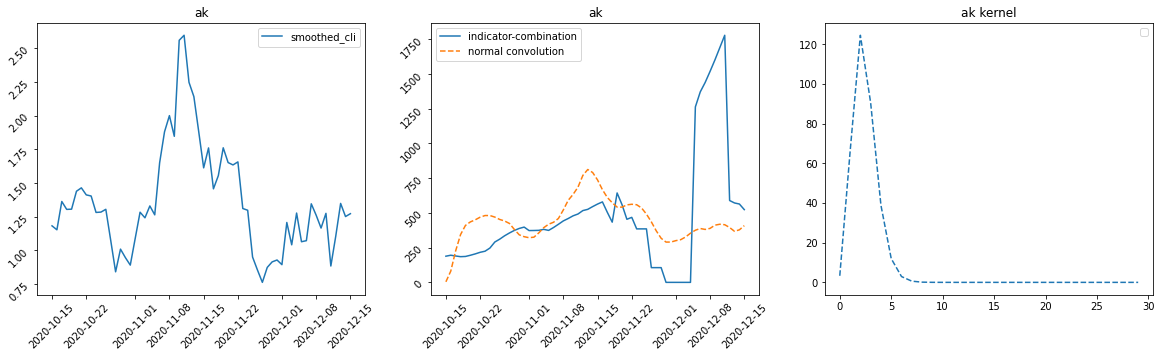

No handles with labels found to put in legend.


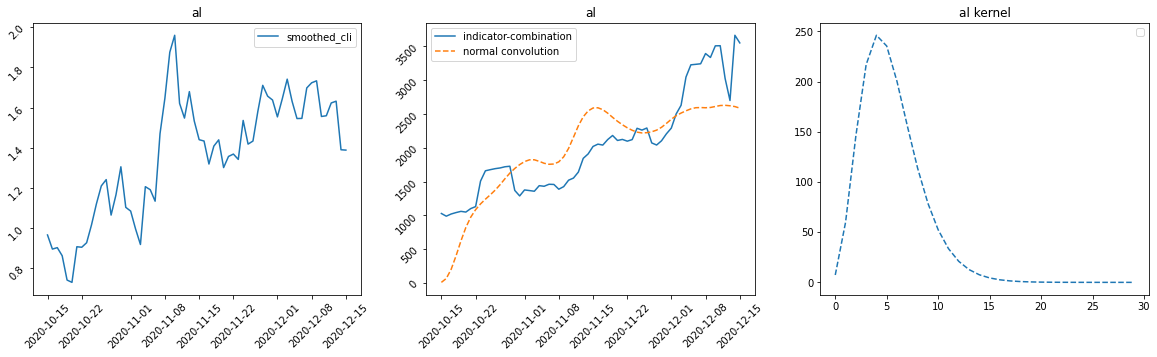

No handles with labels found to put in legend.


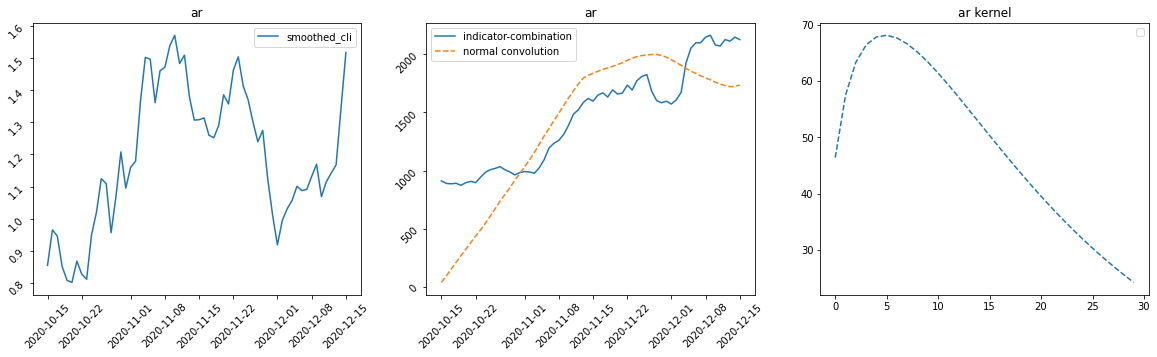

No handles with labels found to put in legend.


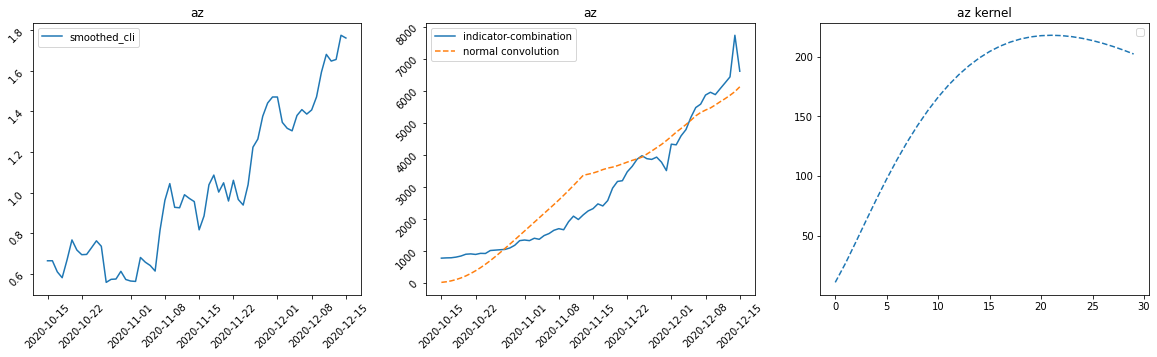

No handles with labels found to put in legend.


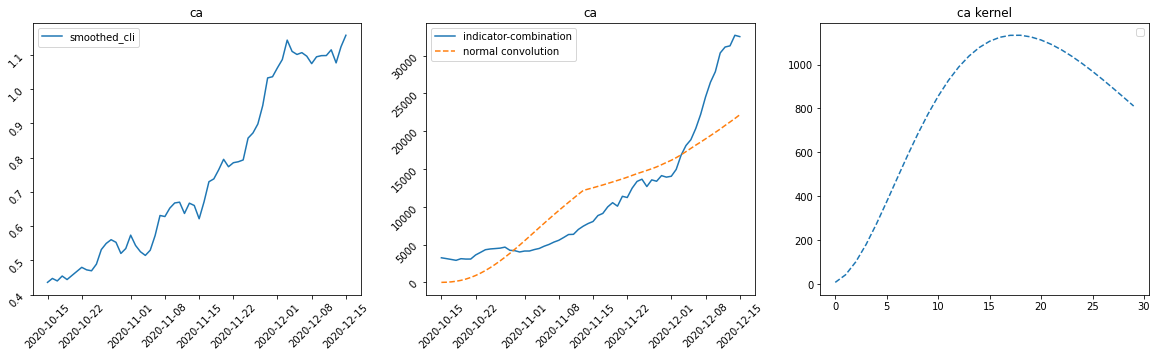

No handles with labels found to put in legend.


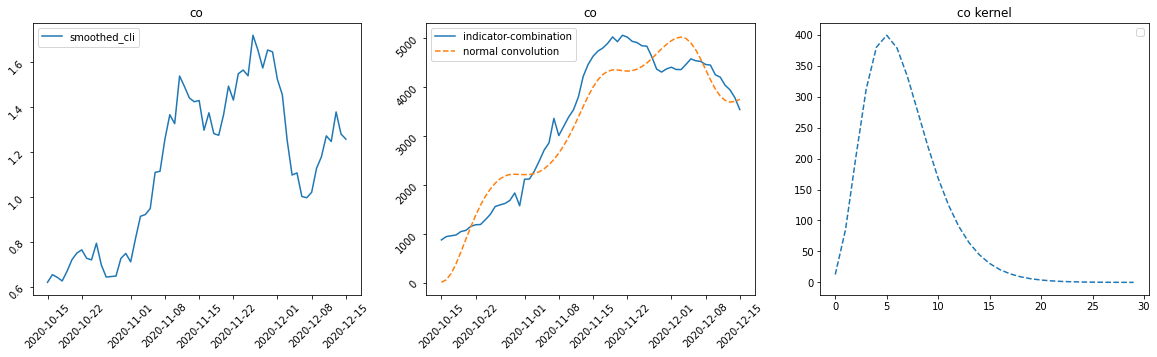

No handles with labels found to put in legend.


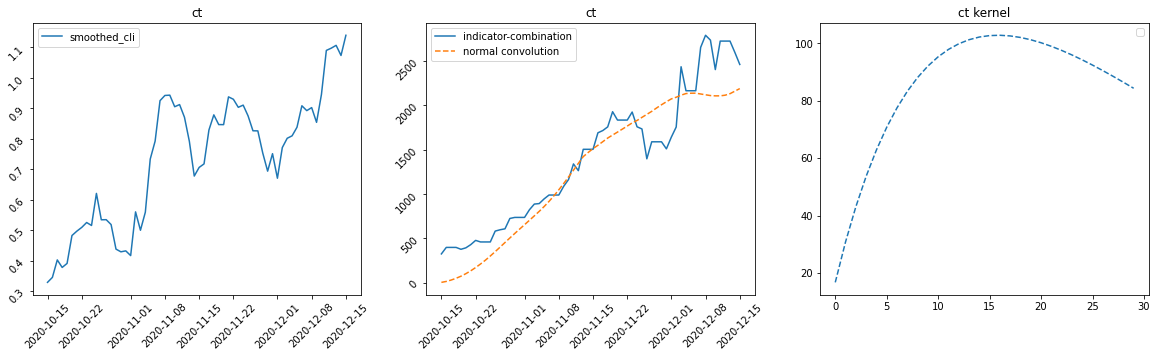

No handles with labels found to put in legend.


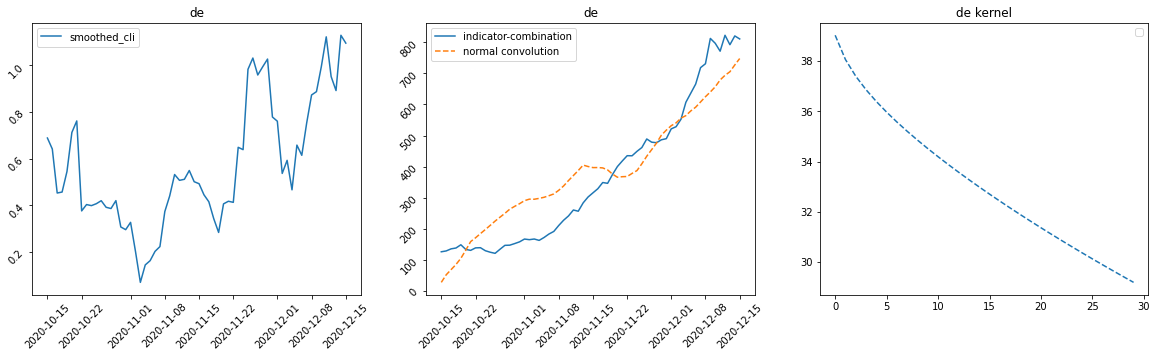

No handles with labels found to put in legend.


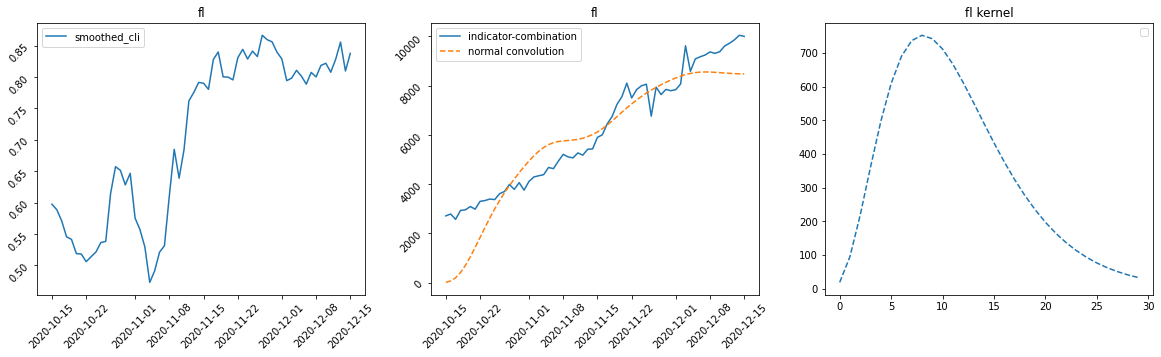

No handles with labels found to put in legend.


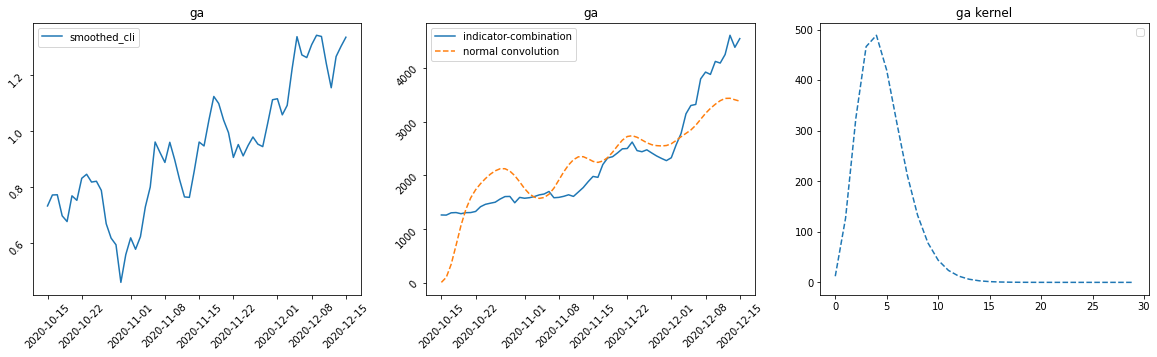

No handles with labels found to put in legend.


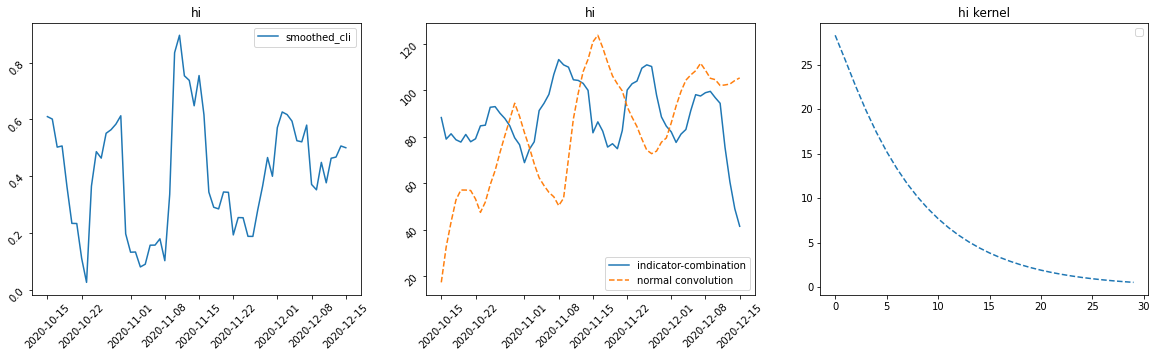

No handles with labels found to put in legend.


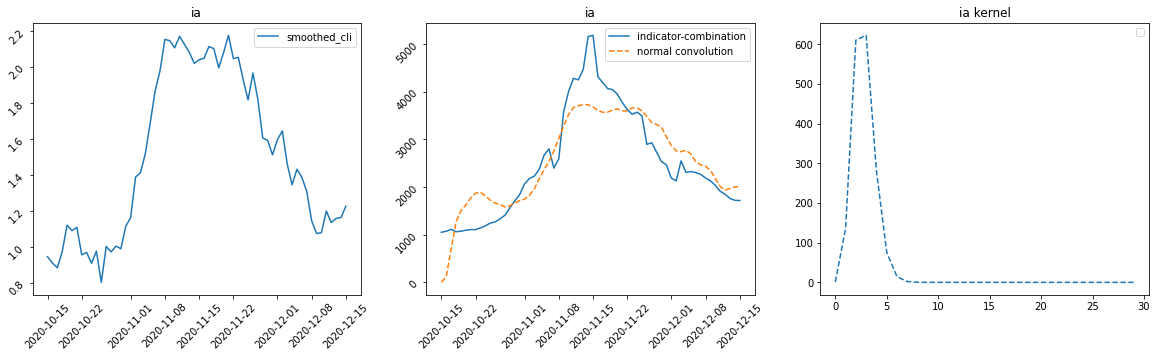

No handles with labels found to put in legend.


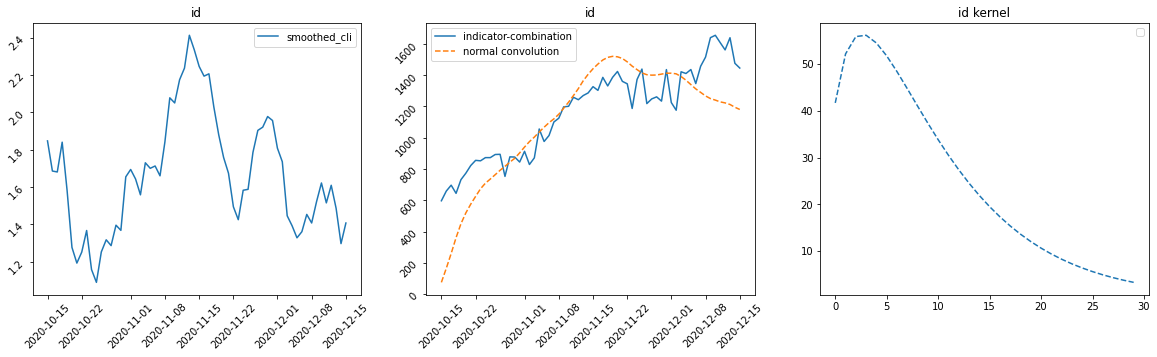

No handles with labels found to put in legend.


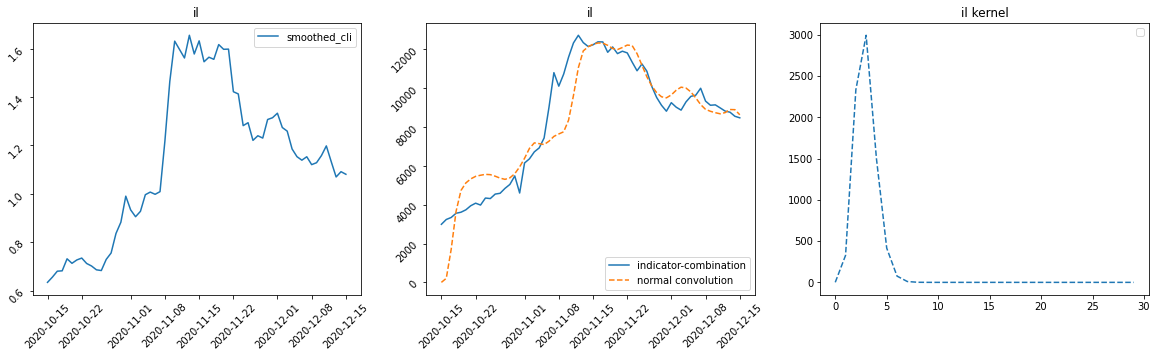

No handles with labels found to put in legend.


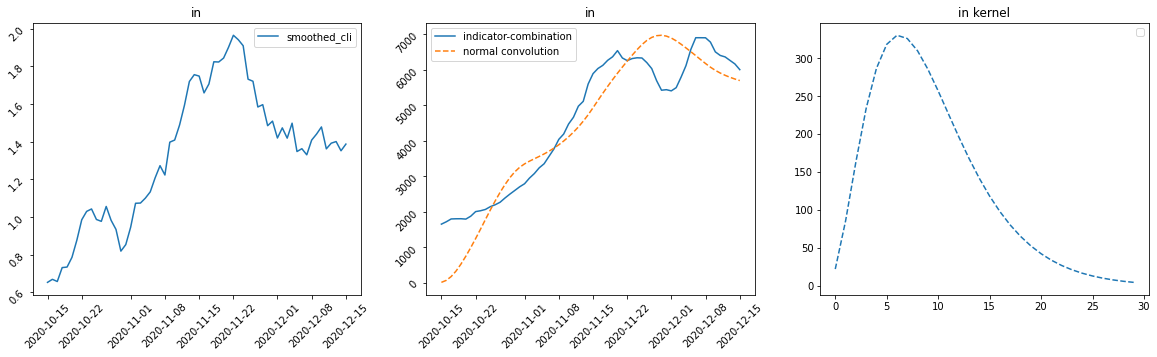

No handles with labels found to put in legend.


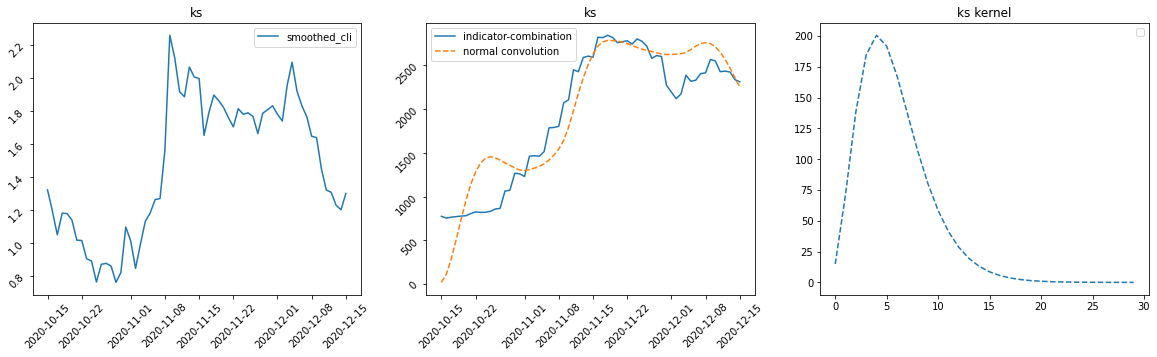

No handles with labels found to put in legend.


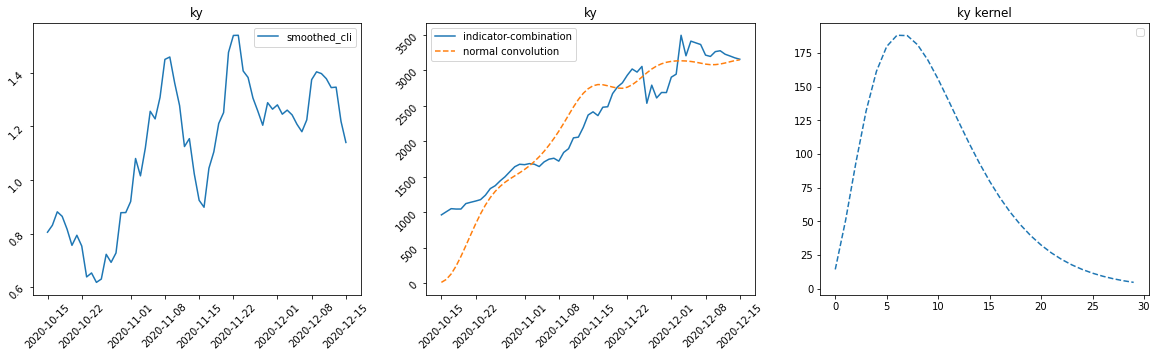

No handles with labels found to put in legend.


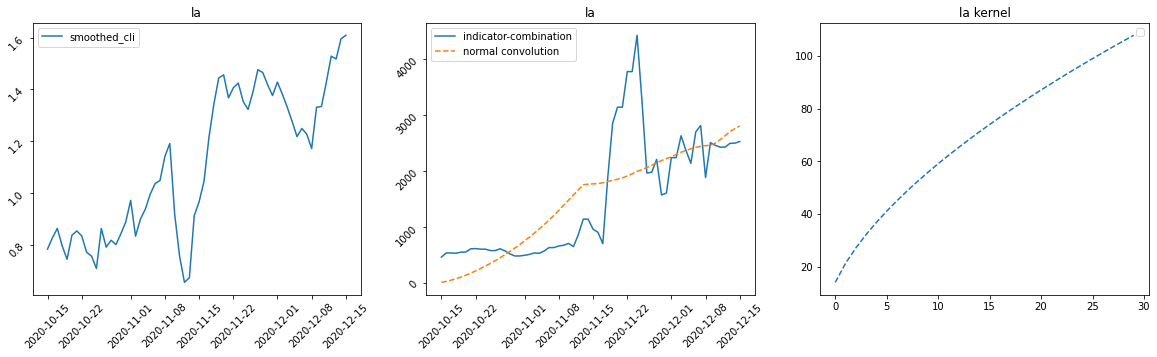

No handles with labels found to put in legend.


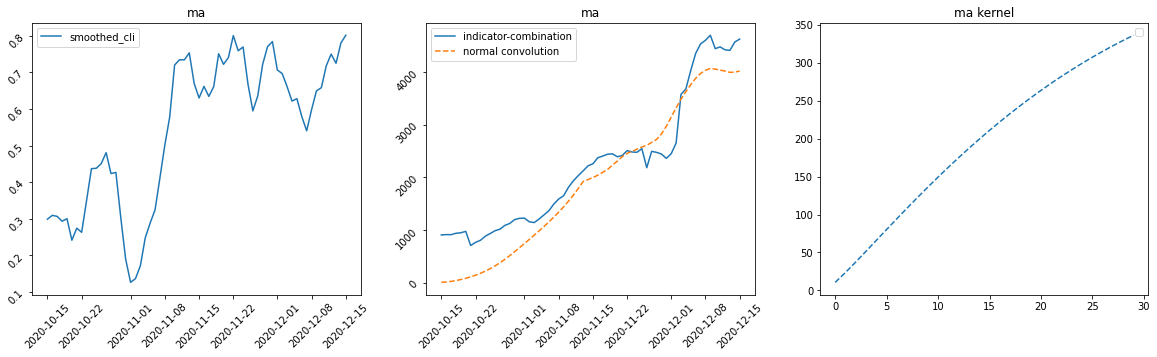

No handles with labels found to put in legend.


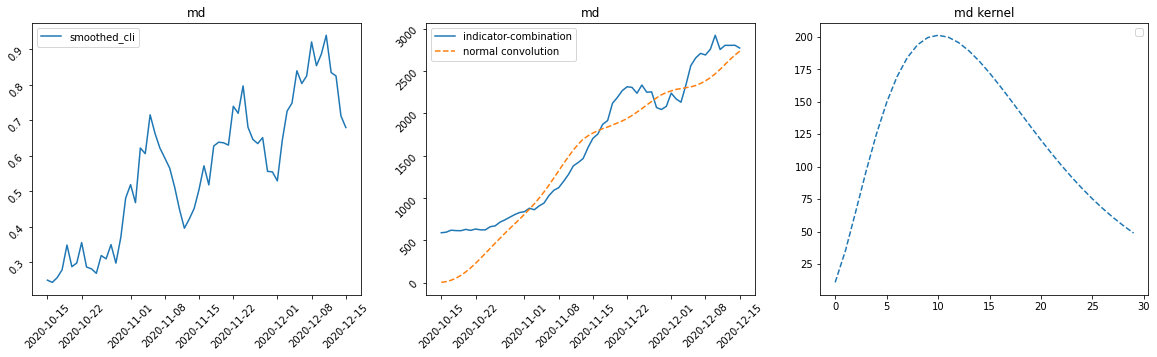

No handles with labels found to put in legend.


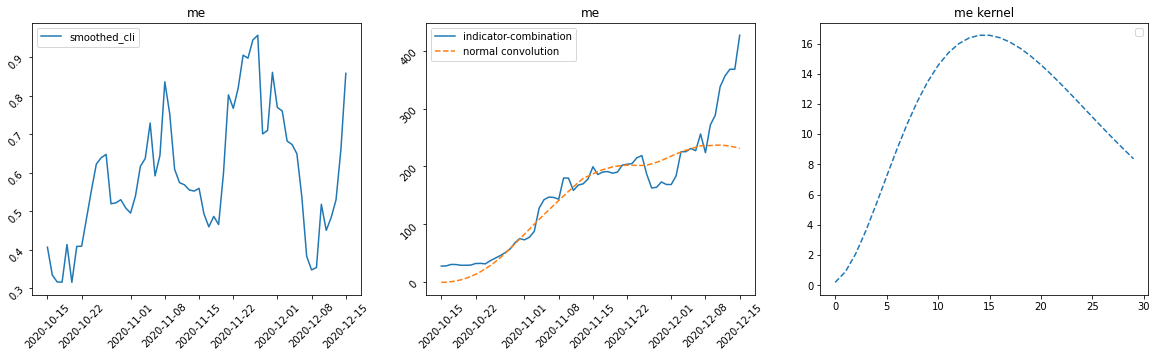

No handles with labels found to put in legend.


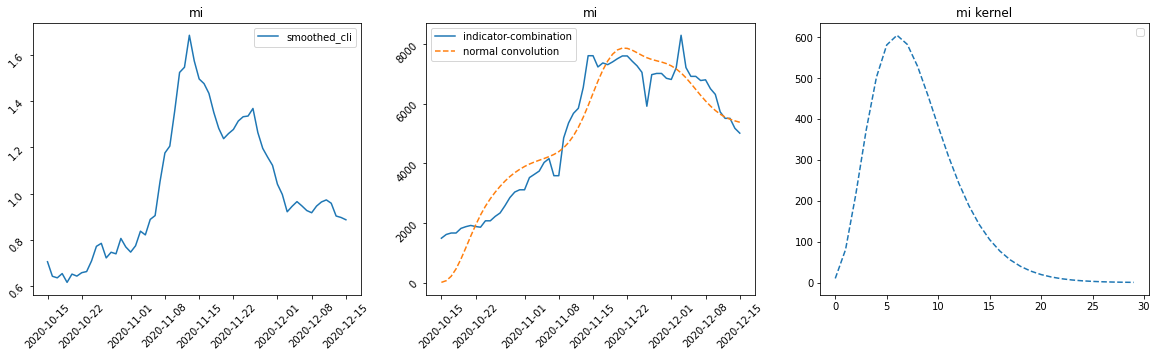

No handles with labels found to put in legend.


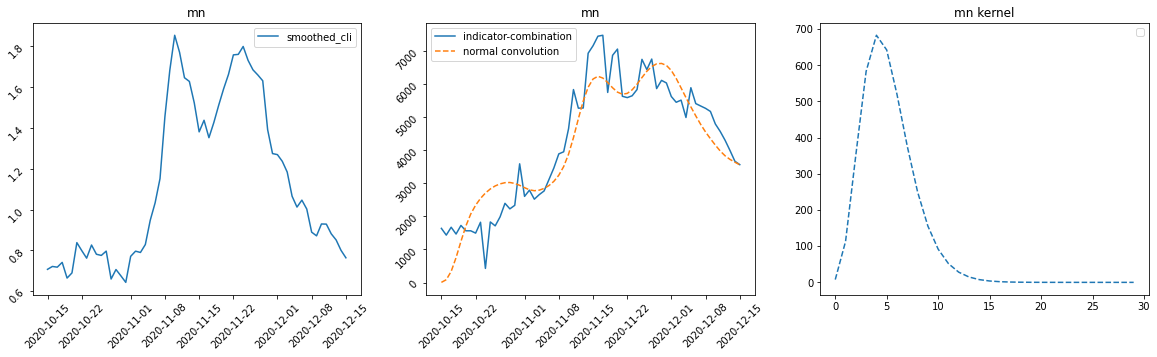

No handles with labels found to put in legend.


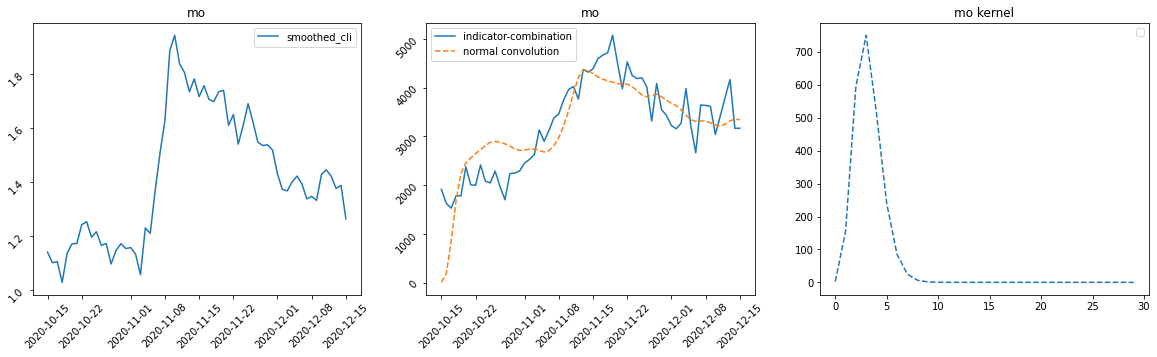

No handles with labels found to put in legend.


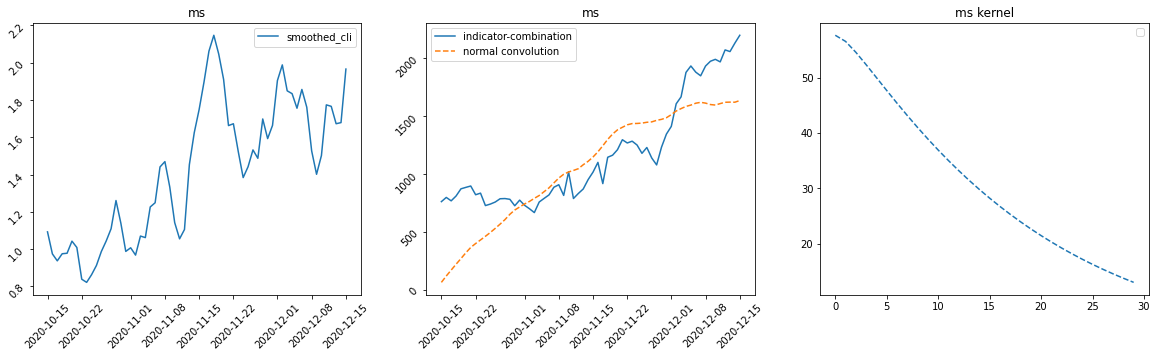

No handles with labels found to put in legend.


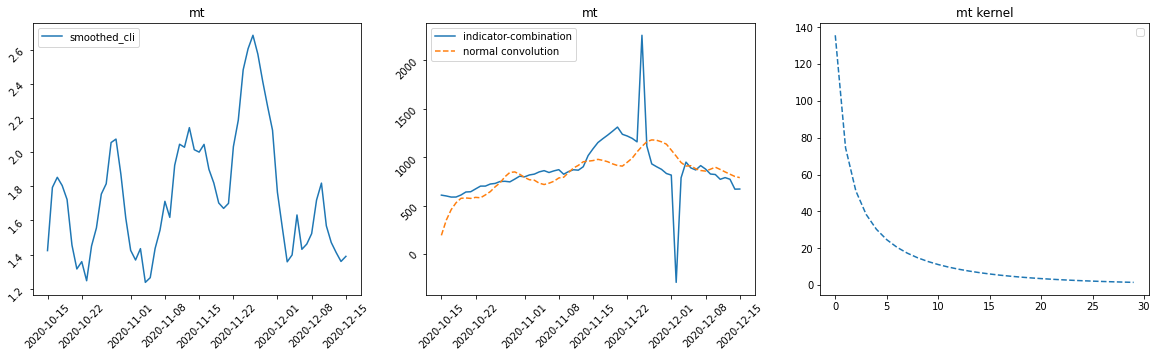

No handles with labels found to put in legend.


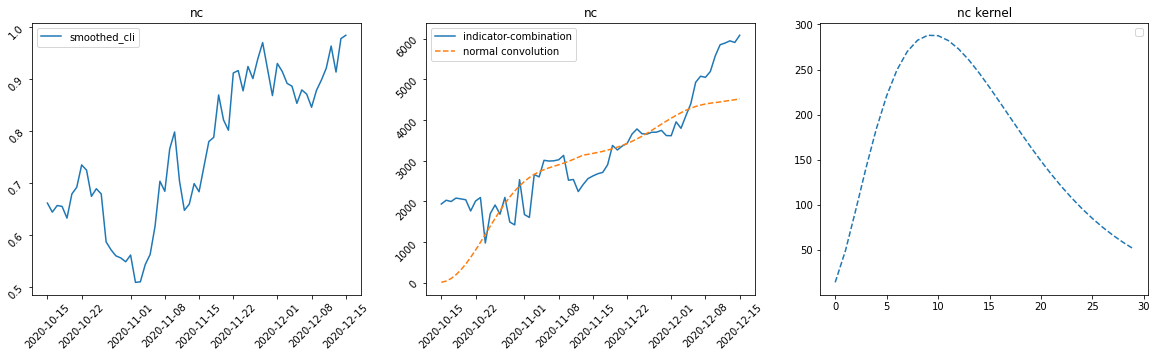

No handles with labels found to put in legend.


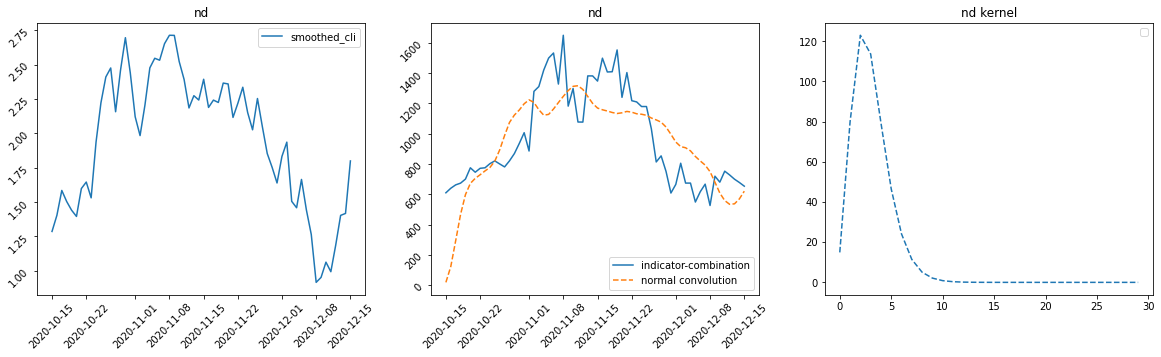

No handles with labels found to put in legend.


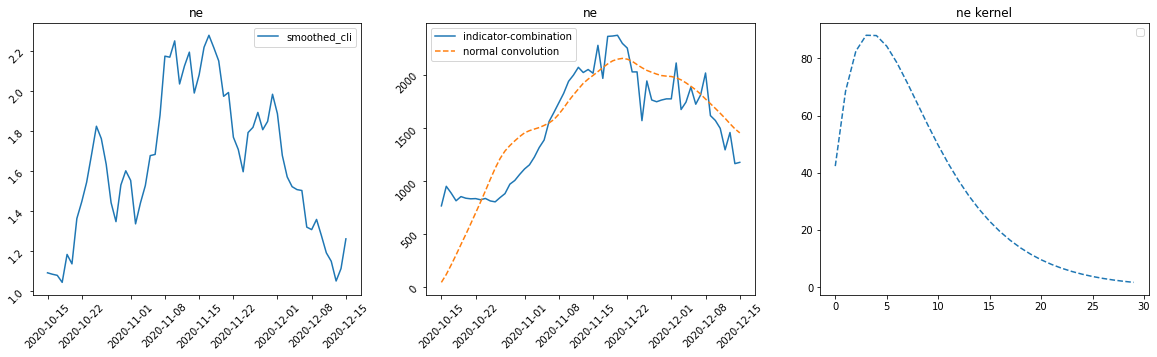

No handles with labels found to put in legend.


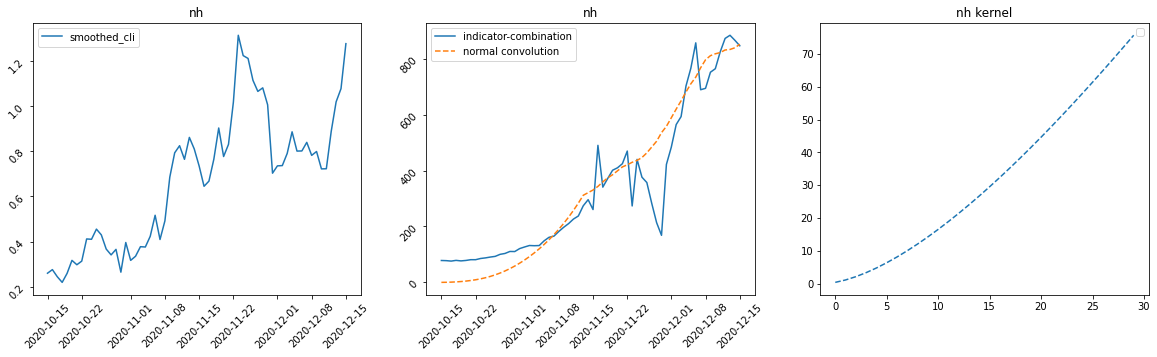

No handles with labels found to put in legend.


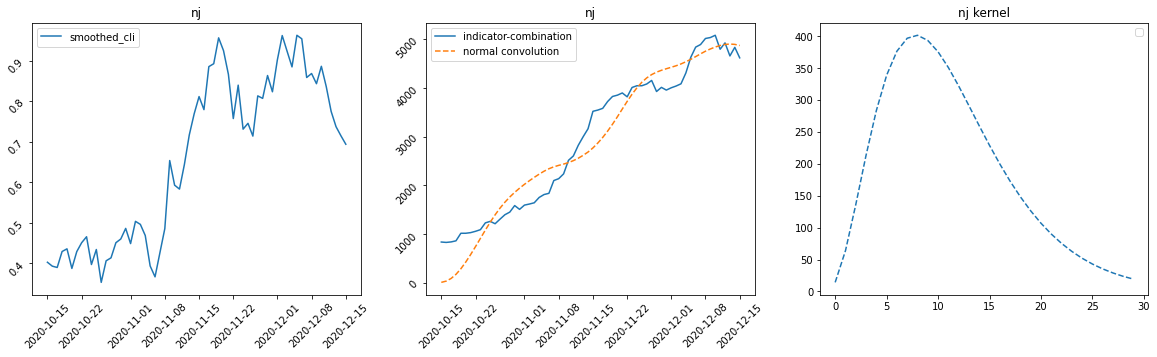

No handles with labels found to put in legend.


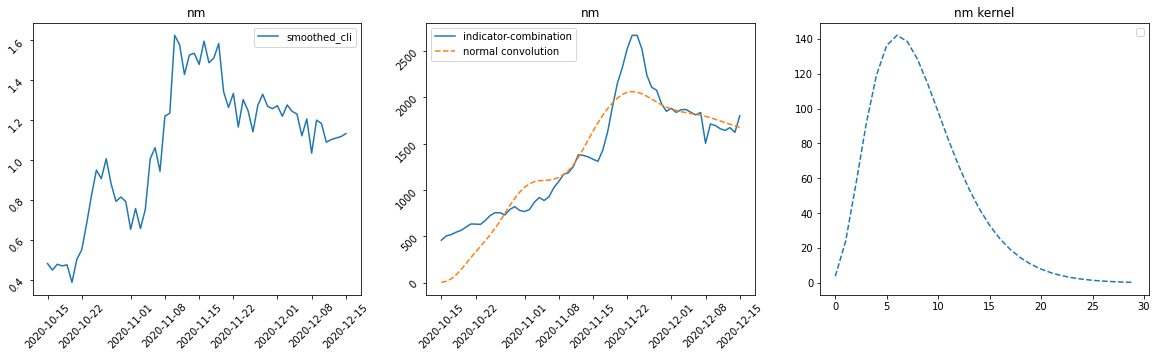

No handles with labels found to put in legend.


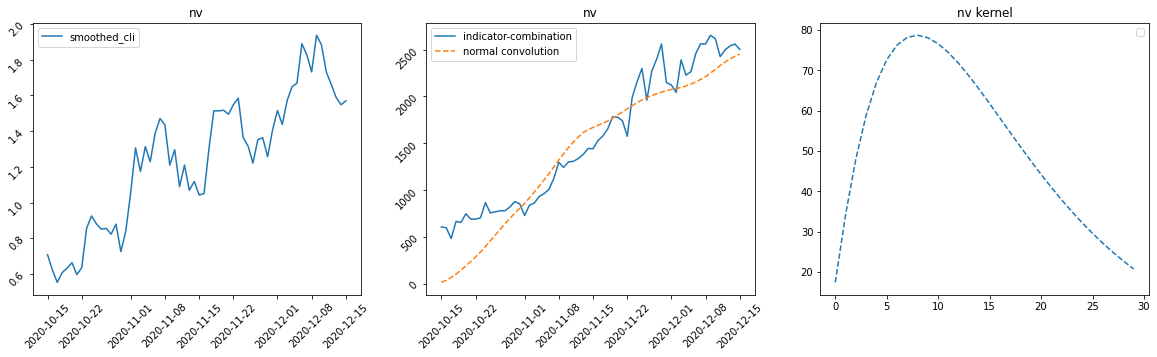

No handles with labels found to put in legend.


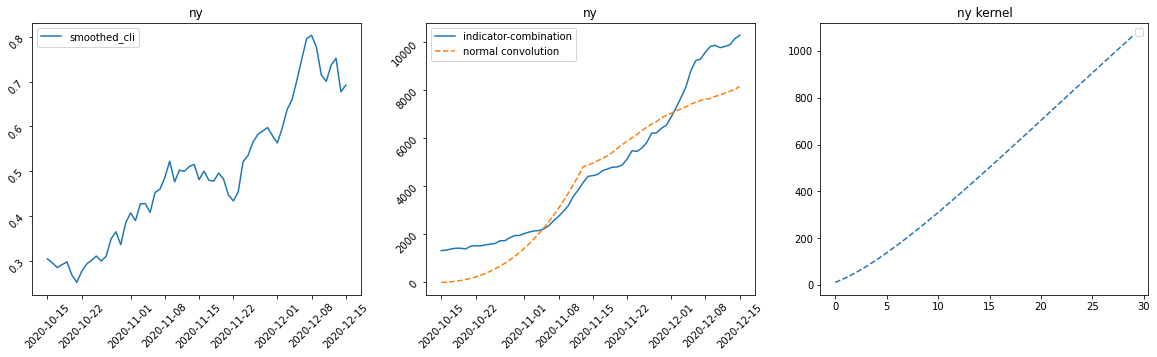

No handles with labels found to put in legend.


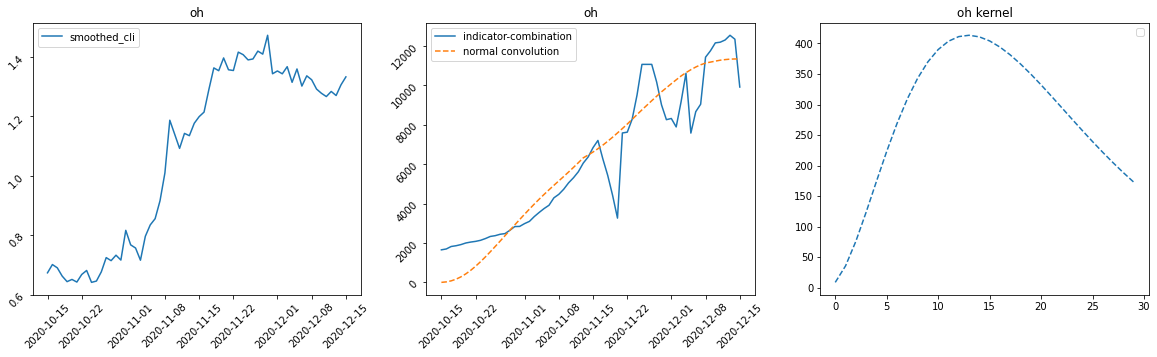

No handles with labels found to put in legend.


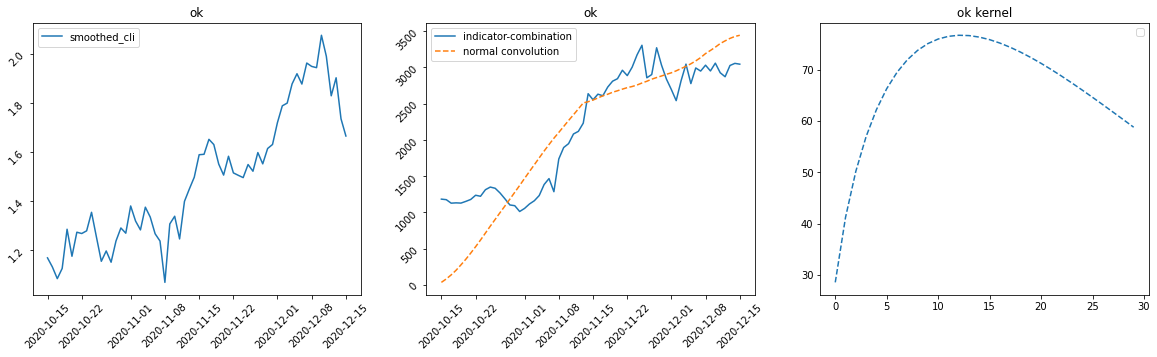

No handles with labels found to put in legend.


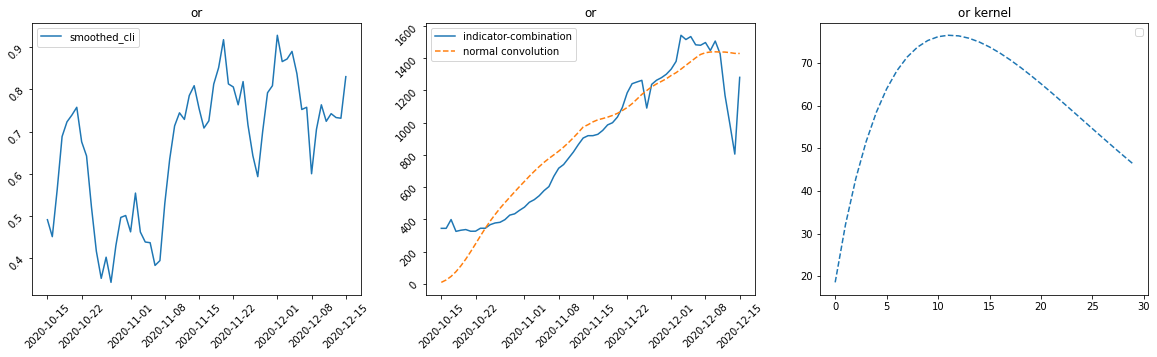

No handles with labels found to put in legend.


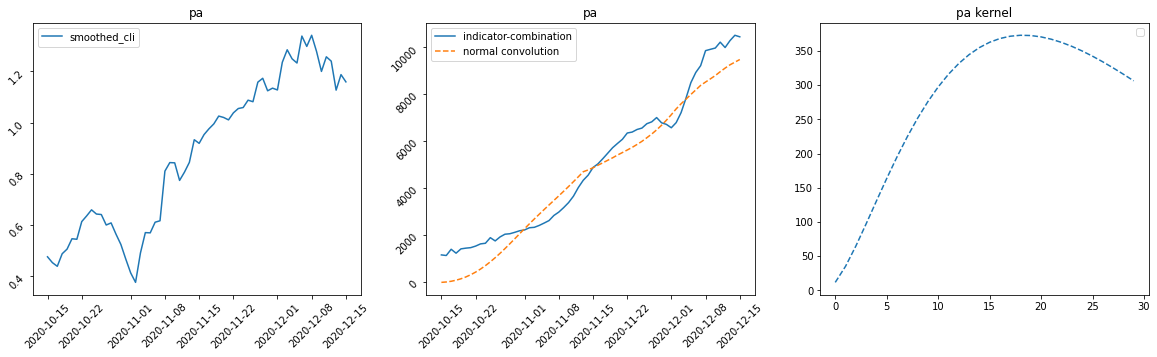

No handles with labels found to put in legend.


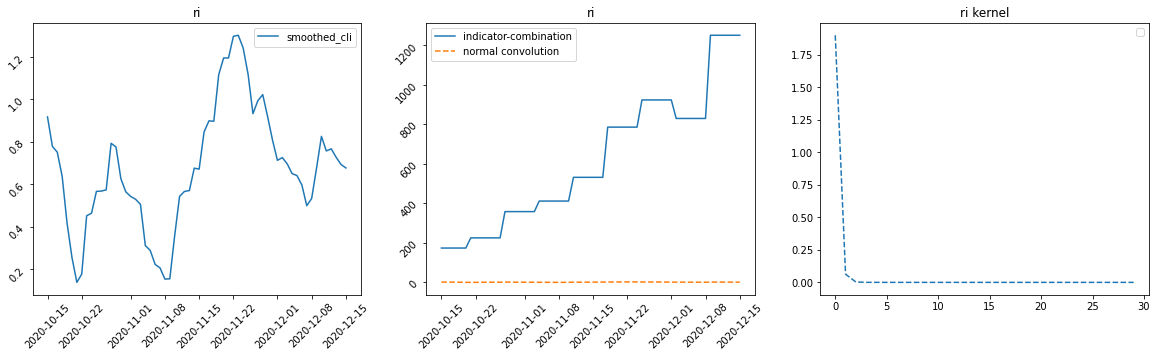

No handles with labels found to put in legend.


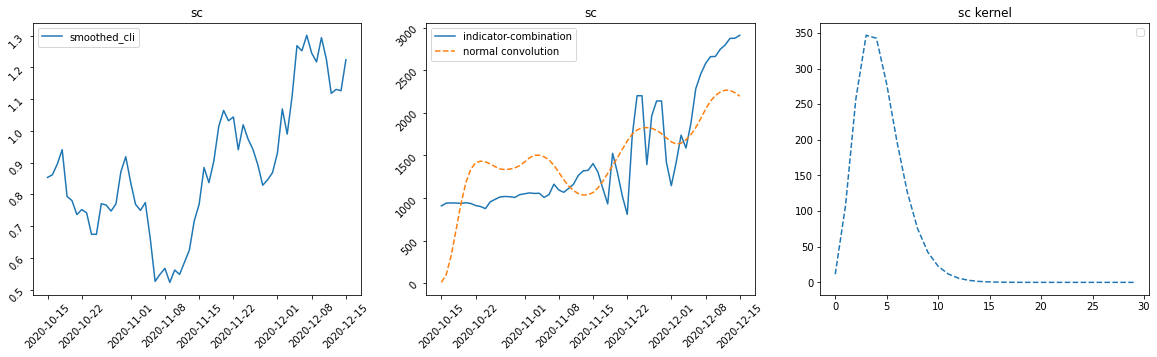

No handles with labels found to put in legend.


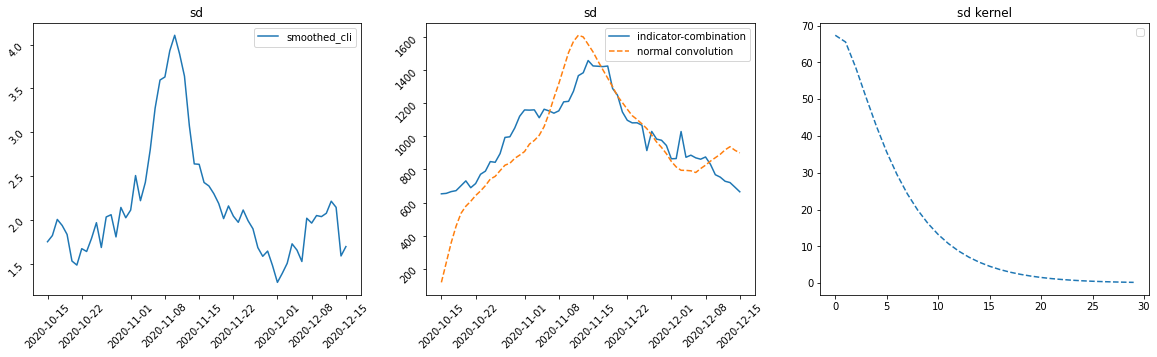

No handles with labels found to put in legend.


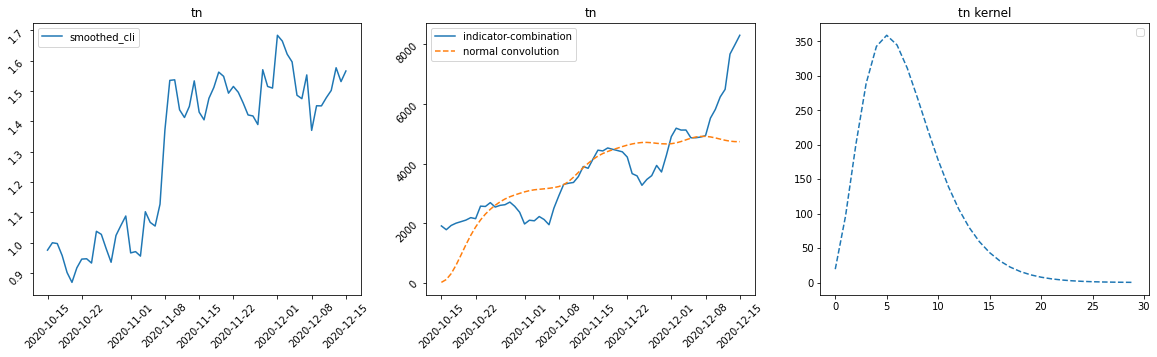

No handles with labels found to put in legend.


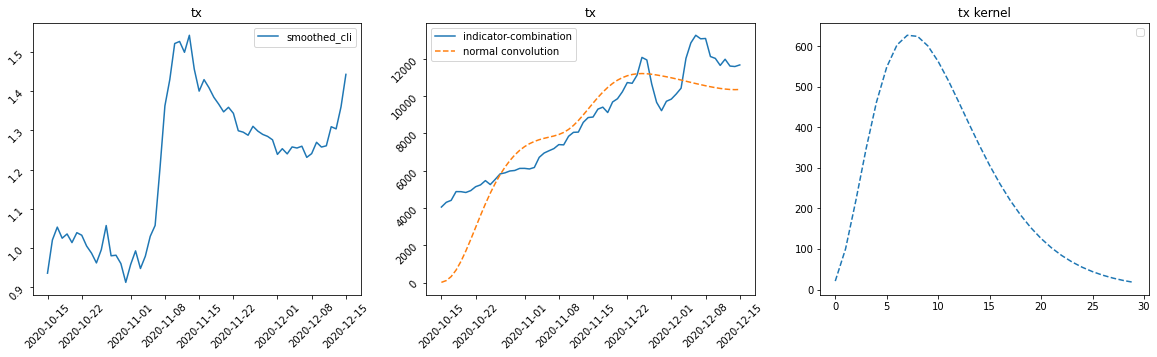

No handles with labels found to put in legend.


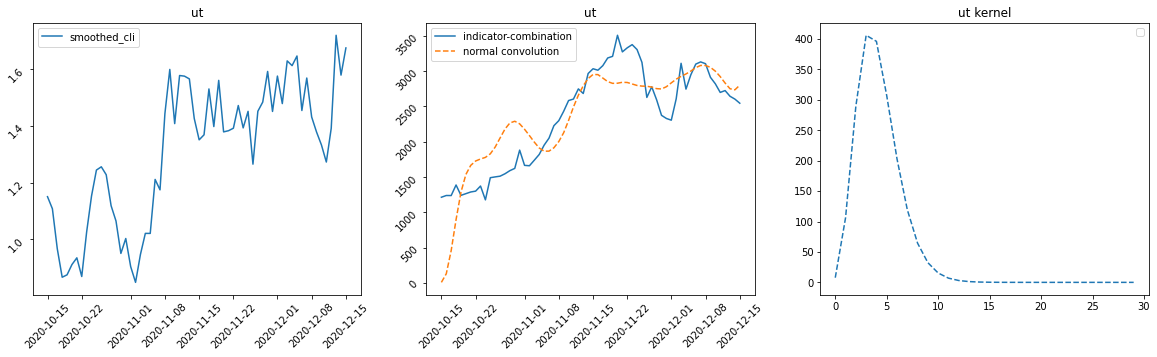

No handles with labels found to put in legend.


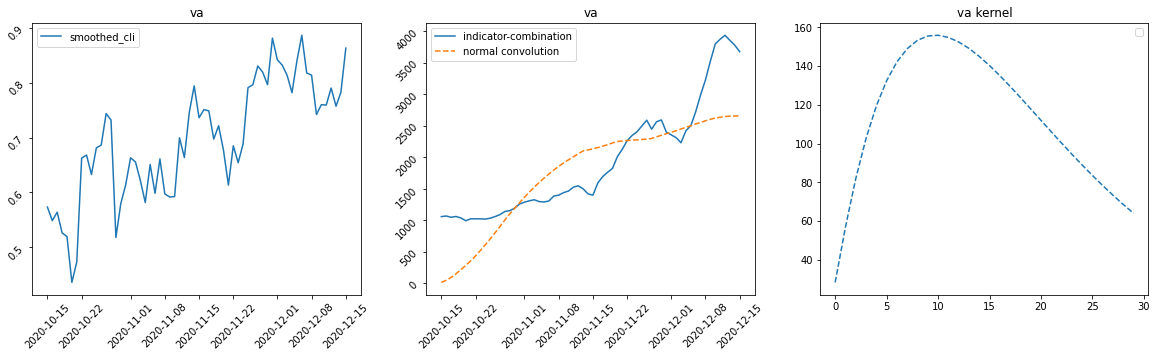

No handles with labels found to put in legend.


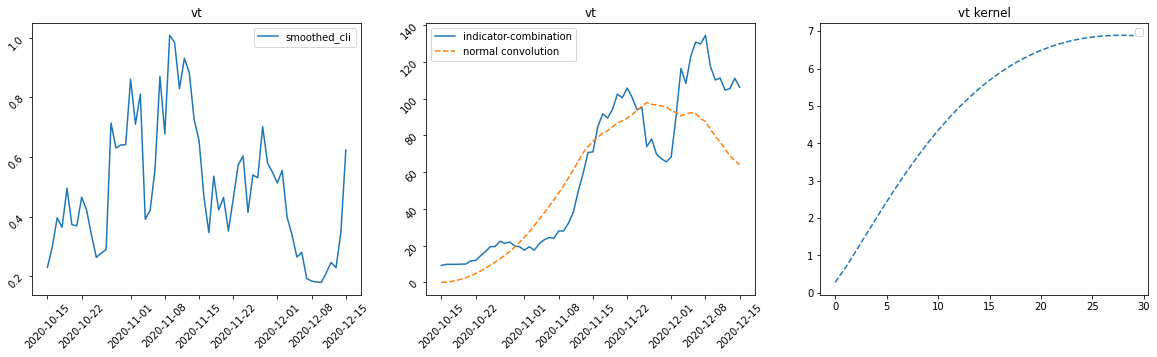

No handles with labels found to put in legend.


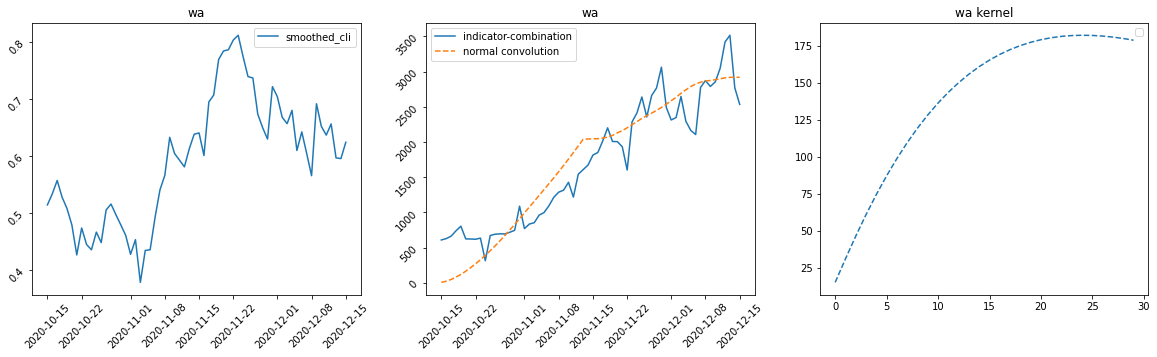

No handles with labels found to put in legend.


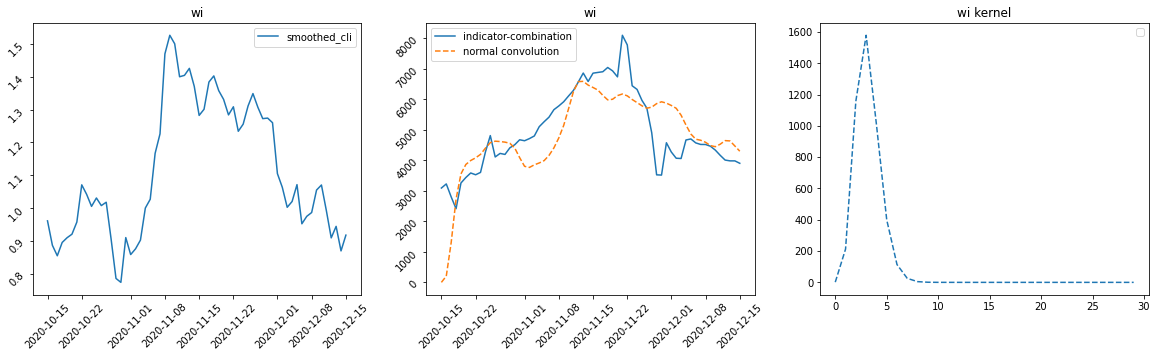

No handles with labels found to put in legend.


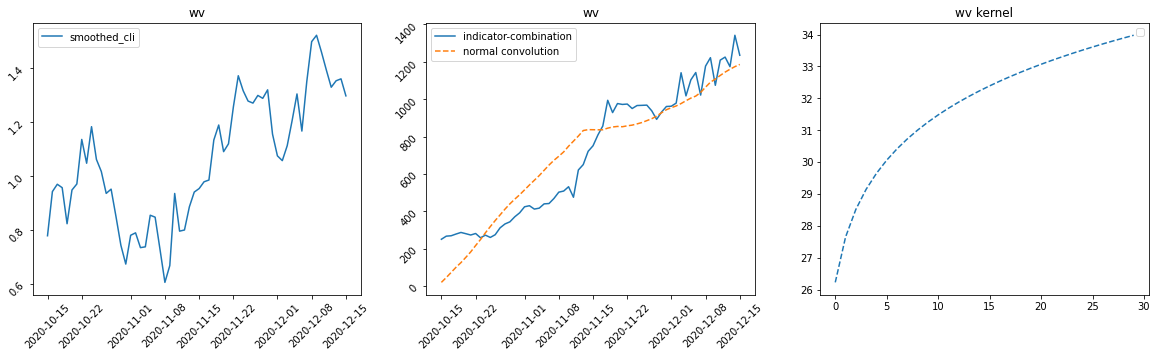

No handles with labels found to put in legend.


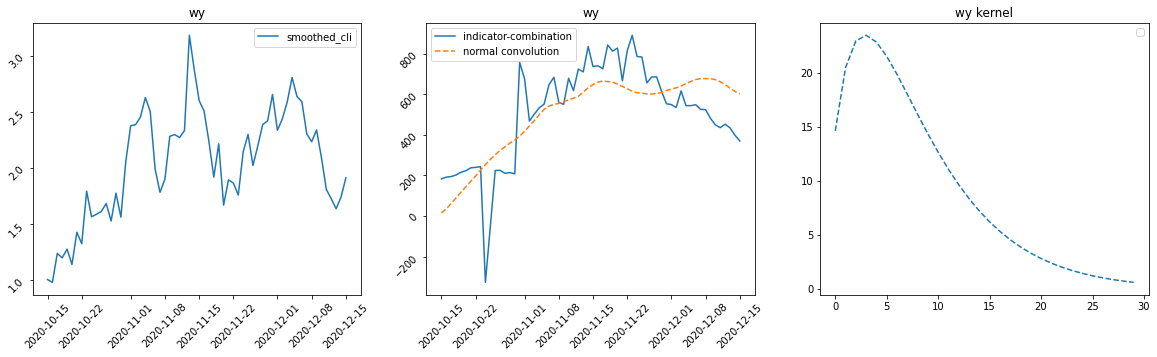

In [17]:
#Evaluation
model_a.load_weights(MODEL_A_PATH).expect_partial() #load best weights from training

dates = X_df['time_value'].sort_values().unique()
X_padded = tf.pad(
    X[:,:,:],
    paddings=[[0, 0], [p-1, 0], [0, 0]],
)
Y_hat_model_a = model_a(X_padded)

for i in range(len(states)):
    y = Y_df[Y_df['geo_value']==states[i]]['value']
    x = X_df[X_df['geo_value']==states[i]]['value']
    y_hat_model_a = Y_hat_model_a[0,:,i]
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
    ax[0].plot(dates, x, label='smoothed_cli')
    ax[0].legend()
    ax[0].set_title('{}'.format(states[i]))
    ax[0].tick_params(labelrotation=45)
    
    ax[1].plot(dates, y, label='indicator-combination')
    ax[1].plot(dates, y_hat_model_a, label='normal convolution', linestyle='--')
    #ax[1].plot(dates, y_hat_model_b, label='convolution with filter bank [1,0,0,...]', linestyle='--')
    ax[1].legend()
    ax[1].set_title('{}'.format(states[i]))
    ax[1].tick_params(labelrotation=45)
    
    #ax[2].plot(model_a.trainable_variables[i][::-1,0,0], label='normal convolutional kernel', linestyle='--')
    ax[2].plot(get_kernel(model_a,i)[::-1], linestyle='--')
    #ax[3].plot(get_kernel(model_c,i)[::-1], label='filter bank [1,1,0,...]', linestyle='--')
    ax[2].legend()
    ax[2].set_title('{} kernel'.format(states[i]))
    
    plt.show()

In [9]:
model_a.conv_layers[7].kernel[0,0,0,:]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>

In [ ]:
states[7]